In [16]:
from adblockparser import AdblockRules
import tldextract
import re
import collections
import matplotlib
import matplotlib.pyplot as plt
import os, fnmatch

In [17]:
partner_dictionary = {}

def adblockparser_parse(rule_list):
    return AdblockRules(rule_list)

def return_domain(rule_line):
    rule = []
    rule.append(rule_line)
    easylist_adblock_rules = adblockparser_parse(rule)
    domain = ''

    # print("rule list ----->", rule)
    # print("Value of r ---->", easylist_adblock_rules.rules)
    for r in easylist_adblock_rules.rules:
        y = r.rule_text
        x = y
        if x[:2] == '||':
            if '^' in x:
                split = x.index("^")
                x = x[2:split]
            else:
                x = x[2:]
        elif x[:1] =='|':
            x = x[1:]

        # print("from return domain -->",x)
        domain = tldextract.extract(x).domain

    return domain

def check_if_valid_domain(hostname):
    if len(hostname) > 255:
        return False
    hostname = hostname.rstrip(".")
    allowed = re.compile('^[a-z0-9]([a-z0-9\-\_]{0,61}[a-z0-9])?$',
                         re.IGNORECASE)
    labels = hostname.split(".")

    # the TLD must not be all-numeric
    if re.match(r"^[0-9]+$", labels[-1]):
        return False

    return all(allowed.match(x) for x in labels)

def extract_partner_domain():

    global partner_dictionary
    partner_count_not_unique = 0

    with open('processed-dec-2019-exceptionrules-latest.txt') as fexception:
        partner = ''
        domain=''
        for line in fexception:
            line = line.rstrip()

            
            if line[0] == '[':
                partner = line[1:-1]
                if partner not in partner_dictionary.keys():
                    partner_count_not_unique+=1
                    partner_dictionary.update({partner:{'collaborators':[],'surrogate':[]}})

            if 'sitekey' in line:  # sitekey coz tld couldnt parse with sitekey in options
                split = line.index("sitekey")
                line = line[:split]
                # print("Line cut 1--->",line)
                if line[-1] == '$' or line[-1] ==',':
                    line = line[:-1]
                # print("Line cut 2---->",line)

            if '#@#' or '###' in line:
                split=-1
                if '#@#' in line:
                    split = line.index("#@#")
                if '###' in line:
                    split = line.index("###")

                if split >0:
                    line = line[:split]
                    # print("Line cut 3--->",line)

            if line[0] != '[':
                domain = return_domain(line)
                if check_if_valid_domain(domain) == False:
                    continue
                else:
                    partner_dictionary[partner]['collaborators'].append(domain)

            if line.find("$") >= 0 and partner != '':
                if (check_if_valid_domain(return_domain(line))) != False:
                    option_separator_index = line.find("$")
                    options_list = line[option_separator_index + 1:]
                    while options_list != "":
                        option_full = ""
                        split = options_list.index(",") if "," in options_list else -1
                        if split == -1:
                            option_full = options_list
                            options_list = ""
                        else:
                            option_full = options_list[:split]
    

                        list_exists = option_full.index("=") if "=" in option_full else -1

                        # case when lists are present - domain, sitekey cases
                        if list_exists != -1:
                            option_name = option_full[:list_exists]
                            if option_name == 'domain':
                                option_full = option_full[list_exists + 1:]
                                while option_full != "":
                                    next_index = option_full.index("|") if "|" in option_full else -1

                                    # case when there are no more lists present
                                    if next_index == -1:
                                        if option_full[0] == '~':
                                                option_full=option_full[1:]
                                                partner_dictionary[partner]['surrogate'].append(return_domain(option_full))
                                        else:
                                            partner_dictionary[partner]['surrogate'].append(return_domain(option_full))

                                        option_full = ""

                                    # case when there are options present in list
                                    else:

                                        curr_option = option_full[:next_index]
                                        if curr_option[0] == '~':
                                            curr_option = curr_option[1:]
                                            partner_dictionary[partner]['surrogate'].append(return_domain(curr_option))
                                        else:
                                            partner_dictionary[partner]['surrogate'].append(return_domain(curr_option))
                                        option_full = option_full[next_index + 1:]

                        options_list = options_list[split + 1:]
    print("Partner count -->",partner_count_not_unique)
                    
                        
extract_partner_domain()


    # print(partner_dictionary)

# with open('partner-collaborator.txt','w') as f:
#     for partner,partner_details in partner_dictionary.items():
#         f.write('partner------>'+partner)
#         f.write('\n')
#         for partner_type ,partner_list in partner_details.items():
#             f.write("partner type ----->"+partner_type)
#             for item in partner_list:
#                 f.write('\n')
#                 f.write(item)
#             f.write('\n')

Partner count --> 637


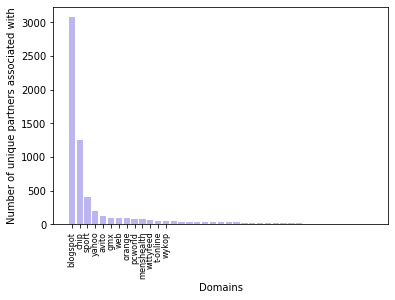

In [18]:
def graph_gen():
    global partner_dictionary

    # get all the collaborators
    
#     font = {'family': 'Liberation Serif',
#         'weight' : 'normal',
#         'size'   : 15
#        }
    
#     matplotlib.rcParams['axes.titlesize'] = 20
#     matplotlib.rcParams['axes.labelsize'] = 15  
#     matplotlib.rc('font', **font)
#     matplotlib.rcParams['text.usetex'] = True
#     matplotlib.rcParams['pdf.fonttype']= 42
#     matplotlib.rcParams['pdf.use14corefonts']=True

    l=[]
    for key in partner_dictionary.keys():
        l.extend(partner_dictionary[key]['collaborators'])

    w = collections.Counter(l)

    w_dup ={}

    listofTuples = sorted(w.items(), key=lambda x: x[1], reverse=True)

    for elem in listofTuples:
        if elem[1] >20:
            w_dup.update({elem[0]:elem[1]})
#     print(w_dup)
    plt.xticks(range(len(w_dup.keys())), w_dup.keys(), rotation=90, fontsize=8)
    plt.bar(list(w_dup.keys()), list(w_dup.values()),color='#BDB5ED')
    plt.xlabel('Domains')
    plt.ylabel(' Number of rules containing domains')
#     plt.tight_layout()
#     plt.savefig('surrogate_domains.pdf')
#     plt.savefig('surrogate_domains.pdf', format='pdf', dpi=1200)
#     plt.show()

    plt.savefig('ER-collaborator-domains.pdf', format='pdf', dpi=1200)
    
    
    # map surrogate domains with number of partners
    
    s = {}
    
    for partner in partner_dictionary.keys():
        for surrogate_domain in partner_dictionary[partner]['surrogate']:
            if surrogate_domain in s.keys():
                s[surrogate_domain][0].add(partner)
            else:
                s.update({surrogate_domain:[set(),0]})
                s[surrogate_domain][0].add(partner)
                
    for domain in s:
        s[domain][1] = len(s[domain][0])

#     print(s)
    
    w={}

    for domain in s:
        w.update({domain:s[domain][1]})
    
    listofTuples = sorted(w.items(), key=lambda x: x[1], reverse=True)
        
    w_dup={}
    for elem in listofTuples:
        if elem[1] >4:
            w_dup.update({elem[0]:elem[1]})
#     print(w_dup)

    


    
    
    plt.xticks(range(len(w_dup.keys())), w_dup.keys(), rotation=90, fontsize=8)
    plt.bar(list(w_dup.keys()), list(w_dup.values()),color='#BDB5ED')
    plt.xlabel('Domains')
    plt.ylabel('Number of unique partners associated with')
#     plt.tight_layout()
#     plt.savefig('surrogate_domains.pdf')
#     plt.savefig('surrogate_domains.pdf', format='pdf', dpi=1200)
#     plt.show()

    plt.savefig('ER-surrogate-domains.pdf', format='pdf', dpi=1200)
    
    


graph_gen()

In [14]:
def past_results():
    listOfFiles = os.listdir('/Users/prashanthikanniapanmurthy/Desktop/Evolution-of-tracker-blocking-lists/GraphCodes')
    pattern = "processed-exceptionrules*.txt"
    
    # processed-exceptionrules-2017-march

    data_tmp={}
    
    
    partner_dictionary = {}
    for entry in listOfFiles:
        if fnmatch.fnmatch(entry, pattern):
            print('Running -->',entry)
            with open(entry,"r") as fexception:
                partner = 'dummy' # keeping it as dummy, to retrieve all collaborators irrespective of partners
                partner_dictionary.update({partner:{'collaborators':[],'surrogate':[]}})
                domain=''
                for line in fexception:
                    line = line.rstrip()
                    print(line)
                    if line == '}': # processing of rtf file - or manually remove them before feeding
                        continue
                    if line:
                        if line[-1] == '\\':
                            line = line[:-1]
#                     print(line)

#                     if line[0] == '[':
#                         partner = line[1:-1]
#                         if partner not in partner_dictionary.keys():
#                             partner_dictionary.update({partner:{'collaborators':[],'surrogate':[]}})
#                             partner_count +=1

                    if 'sitekey' in line:  # sitekey coz tld couldnt parse with sitekey in options
                        split = line.index("sitekey")
                        line = line[:split]
                        # print("Line cut 1--->",line)
                        if line[-1] == '$' or line[-1] ==',':
                            line = line[:-1]
                        # print("Line cut 2---->",line)

                    if '#@#' or '###' in line:
                        split=-1
                        if '#@#' in line:
                            split = line.index("#@#")
                        if '###' in line:
                            split = line.index("###")

                        if split >0:
                            line = line[:split]
                            # print("Line cut 3--->",line)

                    domain = return_domain(line)
                    if check_if_valid_domain(domain) == False:
                        continue
                    else:
                        partner_dictionary[partner]['collaborators'].append(domain)

                    if line.find("$") >= 0 and partner != '':
                        if (check_if_valid_domain(return_domain(line))) != False:
                            option_separator_index = line.find("$")
                            options_list = line[option_separator_index + 1:]
                            while options_list != "":
                                option_full = ""
                                split = options_list.index(",") if "," in options_list else -1
                                if split == -1:
                                    option_full = options_list
                                    options_list = ""
                                else:
                                    option_full = options_list[:split]


                                list_exists = option_full.index("=") if "=" in option_full else -1

                                # case when lists are present - domain, sitekey cases
                                if list_exists != -1:
                                    option_name = option_full[:list_exists]
                                    if option_name == 'domain':
                                        option_full = option_full[list_exists + 1:]
                                        while option_full != "":
                                            next_index = option_full.index("|") if "|" in option_full else -1

                                            # case when there are no more lists present
                                            if next_index == -1:
                                                if option_full[0] == '~':
                                                        option_full=option_full[1:]
                                                        partner_dictionary[partner]['surrogate'].append(return_domain(option_full))
                                                else:
                                                    partner_dictionary[partner]['surrogate'].append(return_domain(option_full))

                                                option_full = ""

                                            # case when there are options present in list
                                            else:

                                                curr_option = option_full[:next_index]
                                                if curr_option:
                                                    if curr_option[0] == '~':
                                                        curr_option = curr_option[1:]
                                                        partner_dictionary[partner]['surrogate'].append(return_domain(curr_option))
                                                    else:
                                                        partner_dictionary[partner]['surrogate'].append(return_domain(curr_option))
                                                    option_full = option_full[next_index + 1:]

                                options_list = options_list[split + 1:]

#                 print(partner_dictionary)

#                 with open('partner-collaborator.txt','w') as f:
#                     for partner,partner_details in partner_dictionary.items():
#                         f.write('partner------>'+partner)
#                         f.write('\n')
#                         for partner_type ,partner_list in partner_details.items():
#                             f.write("partner type ----->"+partner_type)
#                             for item in partner_list:
#                                 f.write('\n')
#                                 f.write(item)
#                             f.write('\n')
                            
    
                l=[]
                for key in partner_dictionary.keys():
                    l.extend(partner_dictionary[key]['collaborators'])

                w = collections.Counter(l)

                w_dup ={}

                listofTuples = sorted(w.items(), key=lambda x: x[1], reverse=True)

                for elem in listofTuples:
                    if elem[1] >20:
                        w_dup.update({elem[0]:elem[1]})
                        
                        
                with open('top-domains.txt','w') as f :              
                    i=0
                    f.write(entry)
                    for key,value in w_dup.items():
                        if i>2:
                            break
                        s = key+' : '+str(value)
                        f.write(s)
                        i+=1
                    
                
#                 print(w_dup)
#                 plt.xticks(range(len(w_dup.keys())), w_dup.keys(), rotation=90, fontsize=8)
#                 plt.bar(list(w_dup.keys()), list(w_dup.values()))
#                 plt.xlabel('Domains')
#                 plt.ylabel(' Number of rules containing domains')
#                 plt.show()
#                 plt.savefig(entry[:-4]+'-collaborators.png')
                
past_results()
                    


Running --> processed-exceptionrules-2017-march.txt
@@||google.com/uds/$script,subdocument,document,domain=netzwelt.de
@@||google.com/cse?$subdocument,document,domain=netzwelt.de
@@||guruads.de/api/view/$script,domain=t3n.de
@@||guruads.de/u/b/$image,domain=t3n.de
@@||google.com/adsense/domains/caf.js$sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBANnylWw2vLY4hUn9w06zQKbhKBfvjFUCsdFlb6TdQhxb9RXWXuI4t31c+o8fYOv/s8q1LGPga3DE1L/tHU4LENMCAwEAAQ
@@||google.com/afs/gen_204?$image,sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBANnylWw2vLY4hUn9w06zQKbhKBfvjFUCsdFlb6TdQhxb9RXWXuI4t31c+o8fYOv/s8q1LGPga3DE1L/tHU4LENMCAwEAAQ
@@||gstatic.com/domainads/$image,sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBANnylWw2vLY4hUn9w06zQKbhKBfvjFUCsdFlb6TdQhxb9RXWXuI4t31c+o8fYOv/s8q1LGPga3DE1L/tHU4LENMCAwEAAQ
@@||img.sedoparking.com^$script,image,sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBANnylWw2vLY4hUn9w06zQKbhKBfvjFUCsdFlb6TdQhxb9RXWXuI4t31c+o8fYOv/s8q1LGPga3DE1L/tHU4LENMCAwEAAQ
@@||sedoparking.com/search/$script,sitekey=MFwwDQYJK

||renego.fi/js/px.js?ch=2$domain=renego.fi
||renego.fr/js/px.js?ch=2$domain=renego.fr
||renego.hu/js/px.js?ch=2$domain=renego.hu
||renego.ie/js/px.js?ch=2$domain=renego.ie
||renego.it/js/px.js?ch=2$domain=renego.it
||renego.nl/js/px.js?ch=2$domain=renego.nl
||renego.no/js/px.js?ch=2$domain=renego.no
||renego.ph/js/px.js?ch=2$domain=renego.ph
||renego.pl/js/px.js?ch=2$domain=renego.pl
||renego.se/js/px.js?ch=2$domain=renego.se
@@||g.doubleclick.net/pagead/$script,subdocument,document,domain=brainleg.com
@@||pagead2.googlesyndication.com/pagead/$domain=brainleg.com
heise.de#@#a[href^="http://pubads.g.doubleclick.net/"]
heise.de#@#.teaser_adliste
heise.de#@#.us_ad
heise.de#@#.hinweis_anzeige
||heise.de/avw-bin/ivw/CP/difftest/casey$domain=heise.de
@@||adcloud.net^$domain=heise.de,script,image,document,subdocument
@@||doubleclick.net^$popup,domain=heise.de
heise.de###bannerzone [href^="http://pubads.g.doubleclick.net/"] > IMG
@@||google.com/ads/search/module/ads/*/search.js$domain=izito.at

@@||google.com/uds/api/ads/$domain=izito.ae|izito.ba|izito.bg|izito.ch|izito.co.id|izito.co.il|izito.co.ke|izito.co.kr|izito.co.nz|izito.co.th|izito.co.za|izito.com.bo|izito.com.hk|izito.com.mx|izito.com.my|izito.com.ph|izito.com.sg|izito.com.tw|izito.com.ua|izito.com.vn|izito.dk|izito.ee|izito.gr|izito.hk|izito.hr|izito.hu|izito.is|izito.jp|izito.kr|izito.lt|izito.lv|izito.my|izito.ph|izito.pk|izito.ro|izito.rs|izito.sa|izito.se|izito.sg|izito.si|izito.tw|izito.ua|izito.us|izito.vn|izito.wiki|izito.ws|izitosearch.com|vinden.be|vinden.nl|zapmeta.ae|zapmeta.at|zapmeta.ba|zapmeta.bg|zapmeta.ch|zapmeta.cl|zapmeta.co.id|zapmeta.co.il|zapmeta.co.in|zapmeta.co.ke|zapmeta.co.kr|zapmeta.co.nz|zapmeta.co.th|zapmeta.co.uk|zapmeta.co.ve|zapmeta.co.za|zapmeta.com|zapmeta.com.ar|zapmeta.com.bo|zapmeta.com.br|zapmeta.com.co|zapmeta.com.es|zapmeta.com.hk|zapmeta.com.mx|zapmeta.com.my|zapmeta.com.ph|zapmeta.com.pl|zapmeta.com.sg|zapmeta.com.tr|zapmeta.com.tw|zapmeta.com.ua|zapmeta.com.vn|zapmeta.cz|za

@@||google.com/afs/ads?$subdocument,domain=suche.golem.de
suche.golem.de#@##wide_ad_unit2
suche.golem.de#@##narrow_ad_unit
suche.golem.de#@##wide_ad_unit
suche.golem.de#@#.wide_ads
@@||golem.de/_js/rl_art_afc1.js
@@||g.doubleclick.net/pagead/ads^*^url=http%3A%2F%2Fwww.golem.de%2Fnews%2F$script,domain=www.golem.de
@@||golem.de/staticrl/scripts/adsense/golem_csi-$script,domain=www.golem.de
@@||g.doubleclick.net/pagead/ads?*^slotname=7370415692^$subdocument,domain=www.golem.de
www.golem.de#@#.iqadlinebottom
@@||g.doubleclick.net/pagead/ads?*^h=100^*^w=460^$subdocument,domain=www.golem.de
www.golem.de#@#.iqadmarker
www.golem.de#@##iqadtile4
www.golem.de#@##iqadtile9
www.golem.de#@##iqadtile1
www.golem.de#@##superbanner
@@||g.doubleclick.net/pagead/ads?*^slotname=1046066947^$subdocument,domain=www.golem.de
@@||g.doubleclick.net/pagead/ads?*^slotname=9156470827^$subdocument,domain=www.golem.de
@@||g.doubleclick.net/pagead/ads?*^slotname=2522774827^$subdocument,domain=www.golem.de
@@||g.doubl

@@||google.com/afs/$script,subdocument,document,domain=opendi.at|opendi.de|opendi.ch|opendi.be|opendi.ca|opendi.cl|opendi.co|opendi.co.id|opendi.co.nz|opendi.co.uk|opendi.com.ar|opendi.com.au|opendi.com.br|opendi.com.pa|opendi.com.pr|opendi.com.tr|opendi.com.ve|opendi.dk|opendi.es|opendi.fi|opendi.fr|opendi.hu|opendi.hk|opendi.in|opendi.it|opendi.jp|opendi.lu|opendi.mx|opendi.nl|opendi.no|opendi.pe|opendi.pl|opendi.pt|opendi.ro|opendi.se|opendi.si|opendi.sg|opendi.us|stadtbranchenbuch.ch|stadtbranchenbuch.at|stadtbranchenbuch.com|stadtbranchenbuch-berlin.de|stadtbranchenbuch-hamburg.de|stadtbranchenbuch-muenchen.de|stadtbranchenbuch-koeln.de|stadtbranchenbuch-frankfurt.de|stadtbranchenbuch-duesseldorf.de|stadtbranchenbuch-stuttgart.de|stadtbranchenbuch-hannover.de|stadtbranchenbuch-bremen.de|stadtbranchenbuch-nuernberg.de|stadtbranchenbuch-essen.de|stadtbranchenbuch-dresden.de|stadtbranchenbuch-leipzig.de|stadtbranchenbuch-dortmund.de|stadtbranchenbuch-bonn.de|stadtbranchenbuch-karlsru

opendi.at,opendi.de,opendi.ch,opendi.be,opendi.nl,opendi.es###container > DIV[style="position: absolute; top: 115px; margin-left: 810px;"]
@@||yieldkit.com^$third-party
||cloudfront.net/abp/hjdebh67699dwnjldw00.js
@@||googletagservices.com/tag/js/gpt.js$domain=wg-gesucht.de
@@||partner.googleadservices.com/gampad/google_ads_gpt.js$domain=wg-gesucht.de
@@||g.doubleclick.net/gampad/ads^$script,domain=wg-gesucht.de
@@||wg-gesucht.de/google_ads_liste_o_afc.js
@@||ads.travelaudience.com^$script,subdocument,document,domain=wg-gesucht.de
wg-gesucht.de#@#div[id^="listAdPos_"]
wg-gesucht.de#@#div[id^="div-gpt-ad"]
wg-gesucht.de#@##liste_top_ads_wrapper
wg-gesucht.de#@#div[id^="google_ads_"]
wg-gesucht.de#@#a[target="_blank"][href^="http://affiliate.immobilienscout24.de/go.cgi?pid="]
wg-gesucht.de##DIV[id^="div-gpt-ad-"][style^="margin: 11px "]
||mail.bg/px.gif?ch=2&rn=$domain=mail.bg
@@||mail.bg/Advert/$image,~third-party
@@||ads.mail.bg/delivery/ajs.php?zoneid=5^$script,~third-party
@@||ads.ma

@@||rcm-*.amazon.$subdocument,domain=tv-nostalgie.de
@@||amazon-adsystem.$subdocument,image,domain=tv-nostalgie.de
/js/px.js?ch=2$domain=cylex.be|cylex.ch|cylex-bedrijvengids.be|cylex.de|cylex.ca|cylex.com.au|cylex-bedrijvengids.nl|cylex-branchenbuch.ch|cylex-oesterreich.at|cylex-uk.co.uk|cylex-usa.com|cylex.cl|cylex.co.nz|cylex.co.za|cylex.com.ar|cylex.com.br|cylex.com.co|cylex.com.mx|cylex.com.ng|cylex.com.pe|cylex.com.tr|cylex.com.ve|cylex.cz|cylex.dk|cylex.fi|cylex.gr|cylex.ie|cylex.in|cylex.it|cylex.no|cylex.pl|cylex.pt|cylex.se|cylex.sk|cylex-espana.es|cylex-florida.com|cylex-france.fr|cylex.ro|cylex.hu
@@||g.doubleclick.net/pagead/ads^*^h=95^*^w=660^*^ad_type=text_html^$subdocument,document,domain=cylex.be|cylex.ch|cylex-bedrijvengids.be|cylex.de|cylex.ca|cylex.com.au|cylex-bedrijvengids.nl|cylex-branchenbuch.ch|cylex-oesterreich.at|cylex-uk.co.uk|cylex-usa.com|cylex.cl|cylex.co.nz|cylex.co.za|cylex.com.ar|cylex.com.br|cylex.com.co|cylex.com.mx|cylex.com.ng|cylex.com.pe|cylex.co

winfuture.de#@##adblock2
@@||google.com/adsense/domains/caf.js$sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBALquDFETXRn0Hr05fUP7EJT77xYnPmRbpMy4vk8KYiHnkNpednjOANJcaXDXcKQJN0nXKZJL7TciJD8AoHXK158CAwEAAQ
@@||cloudfront.net/scripts/js3caf.js$sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBALquDFETXRn0Hr05fUP7EJT77xYnPmRbpMy4vk8KYiHnkNpednjOANJcaXDXcKQJN0nXKZJL7TciJD8AoHXK158CAwEAAQ
@@||gstatic.com/domainads/$image,sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBALquDFETXRn0Hr05fUP7EJT77xYnPmRbpMy4vk8KYiHnkNpednjOANJcaXDXcKQJN0nXKZJL7TciJD8AoHXK158CAwEAAQ
@@$elemhide,sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBALquDFETXRn0Hr05fUP7EJT77xYnPmRbpMy4vk8KYiHnkNpednjOANJcaXDXcKQJN0nXKZJL7TciJD8AoHXK158CAwEAAQ
@@||g.doubleclick.net/apps/domainpark/$subdocument,sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBALquDFETXRn0Hr05fUP7EJT77xYnPmRbpMy4vk8KYiHnkNpednjOANJcaXDXcKQJN0nXKZJL7TciJD8AoHXK158CAwEAAQ
@@||rcm-de.amazon.de^$subdocument,domain=bibercraft.de
bibercraft.de#@##werbung
@@||an.yandex.ru/system/context.js$domain=pervush

||www.google.kr/images/phd/px.gif
@@||www.google.jp^$elemhide,~third-party
||www.google.jp/images/phd/px.gif
@@||www.google.co.jp^$elemhide,~third-party
||www.google.co.jp/images/phd/px.gif
@@||www.google.ne.jp^$elemhide,~third-party
||www.google.ne.jp/images/phd/px.gif
@@||www.google.co.je^$elemhide,~third-party
||www.google.co.je/images/phd/px.gif
@@||www.google.com.ar^$elemhide,~third-party
||www.google.com.ar/images/phd/px.gif
@@||www.google.am^$elemhide,~third-party
||www.google.am/images/phd/px.gif
@@||www.google.be^$elemhide,~third-party
||www.google.be/images/phd/px.gif
@@||www.google.fm^$elemhide,~third-party
||www.google.fm/images/phd/px.gif
@@||www.google.vg^$elemhide,~third-party
||www.google.vg/images/phd/px.gif
@@||www.google.bi^$elemhide,~third-party
||www.google.bi/images/phd/px.gif
@@||www.google.cc^$elemhide,~third-party
||www.google.cc/images/phd/px.gif
@@||www.google.cd^$elemhide,~third-party
||www.google.cd/images/phd/px.gif
@@||www.google.co.il^$elemhide,~third-pa

||www.google.co.zw/images/phd/px.gif
@@||www.google.com.ag^$elemhide,~third-party
||www.google.com.ag/images/phd/px.gif
@@||www.google.com.ai^$elemhide,~third-party
||www.google.com.ai/images/phd/px.gif
@@||www.google.com.az^$elemhide,~third-party
||www.google.com.az/images/phd/px.gif
@@||www.google.com.bd^$elemhide,~third-party
||www.google.com.bd/images/phd/px.gif
@@||www.google.com.bh^$elemhide,~third-party
||www.google.com.bh/images/phd/px.gif
@@||www.google.com.bi^$elemhide,~third-party
||www.google.com.bi/images/phd/px.gif
@@||www.google.com.bn^$elemhide,~third-party
||www.google.com.bn/images/phd/px.gif
@@||www.google.com.bo^$elemhide,~third-party
||www.google.com.bo/images/phd/px.gif
@@||www.google.com.bs^$elemhide,~third-party
||www.google.com.bs/images/phd/px.gif
@@||www.google.com.by^$elemhide,~third-party
||www.google.com.by/images/phd/px.gif
@@||www.google.com.bz^$elemhide,~third-party
||www.google.com.bz/images/phd/px.gif
@@||www.google.com.cy^$elemhide,~third-party
||www

||www.google.pk/images/phd/px.gif
@@||www.google.pn^$elemhide,~third-party
||www.google.pn/images/phd/px.gif
@@||www.google.pr^$elemhide,~third-party
||www.google.pr/images/phd/px.gif
@@||www.google.re^$elemhide,~third-party
||www.google.re/images/phd/px.gif
@@||www.google.rs^$elemhide,~third-party
||www.google.rs/images/phd/px.gif
@@||www.google.sc^$elemhide,~third-party
||www.google.sc/images/phd/px.gif
@@||www.google.si^$elemhide,~third-party
||www.google.si/images/phd/px.gif
@@||www.google.sk^$elemhide,~third-party
||www.google.sk/images/phd/px.gif
@@||www.google.sl^$elemhide,~third-party
||www.google.sl/images/phd/px.gif
@@||www.google.sm^$elemhide,~third-party
||www.google.sm/images/phd/px.gif
@@||www.google.sn^$elemhide,~third-party
||www.google.sn/images/phd/px.gif
@@||www.google.so^$elemhide,~third-party
||www.google.so/images/phd/px.gif
@@||www.google.sr^$elemhide,~third-party
||www.google.sr/images/phd/px.gif
@@||www.google.st^$elemhide,~third-party
||www.google.st/images/ph

@@||maps.google.az^$elemhide
@@||maps.google.az^$~third-party
@@||maps.google.bf^$elemhide
@@||maps.google.bf^$~third-party
@@||maps.google.bg^$elemhide
@@||maps.google.bg^$~third-party
@@||maps.google.bj^$elemhide
@@||maps.google.bj^$~third-party
@@||maps.google.bm^$elemhide
@@||maps.google.bm^$~third-party
@@||maps.google.bn^$elemhide
@@||maps.google.bn^$~third-party
@@||maps.google.bo^$elemhide
@@||maps.google.bo^$~third-party
@@||maps.google.bs^$elemhide
@@||maps.google.bs^$~third-party
@@||maps.google.bt^$elemhide
@@||maps.google.bt^$~third-party
@@||maps.google.by^$elemhide
@@||maps.google.by^$~third-party
@@||maps.google.bz^$elemhide
@@||maps.google.bz^$~third-party
@@||maps.google.cat^$elemhide
@@||maps.google.cat^$~third-party
@@||maps.google.cf^$elemhide
@@||maps.google.cf^$~third-party
@@||maps.google.cg^$elemhide
@@||maps.google.cg^$~third-party
@@||maps.google.ci^$elemhide
@@||maps.google.ci^$~third-party
@@||maps.google.cm^$elemhide
@@||maps.google.cm^$~third-party
@@||ma

@@||maps.google.ph^$~third-party
@@||maps.google.pk^$elemhide
@@||maps.google.pk^$~third-party
@@||maps.google.pn^$elemhide
@@||maps.google.pn^$~third-party
@@||maps.google.pr^$elemhide
@@||maps.google.pr^$~third-party
@@||maps.google.re^$elemhide
@@||maps.google.re^$~third-party
@@||maps.google.rs^$elemhide
@@||maps.google.rs^$~third-party
@@||maps.google.sc^$elemhide
@@||maps.google.sc^$~third-party
@@||maps.google.si^$elemhide
@@||maps.google.si^$~third-party
@@||maps.google.sk^$elemhide
@@||maps.google.sk^$~third-party
@@||maps.google.sl^$elemhide
@@||maps.google.sl^$~third-party
@@||maps.google.sm^$elemhide
@@||maps.google.sm^$~third-party
@@||maps.google.sn^$elemhide
@@||maps.google.sn^$~third-party
@@||maps.google.so^$elemhide
@@||maps.google.so^$~third-party
@@||maps.google.sr^$elemhide
@@||maps.google.sr^$~third-party
@@||maps.google.st^$elemhide
@@||maps.google.st^$~third-party
@@||maps.google.sz^$elemhide
@@||maps.google.sz^$~third-party
@@||maps.google.tk^$elemhide
@@||maps

@@||r.skimresources.com/api/?$script
@@||t.skimresources.com/api/track.php?$script
@@||i.skimthrough.net/api/$script,xmlhttprequest
@@||p.skimthrough.net/px.gif?ch=1&rn=
||p.skimthrough.net/px.gif?ch=2&rn=
@@||r.skimthrough.net/api/?$script
@@||s.skimthrough.net/js/*.skimlinks.js^$script
@@||t.skimthrough.net/api/track.php?$script
@@||adcell.de/js/jsadlib.js
@@||adcell.de/jsevent.php?$script
@@||adcell.de/event_tracking.php?$script
@@||adcell.de/event.php?$image
@@||zanox-affiliate.de/ppc/$third-party
@@||zanox-affiliate.de/tpv/$third-party
@@||zanox-affiliate.de/pps/$third-party
@@||zanox-affiliate.de/ppl/$third-party
@@||zanox.com/ppc/$third-party
@@||zanox.com/tpv/$third-party
@@||zanox.com/pps/$third-party
@@||zanox.com/ppl/$third-party
@@||belboon.de/adtracking/lead/
@@||belboon.de/adtracking/sale/
@@||belboon.de/adtracking/flash.swf
@@||belboon.de/adtracking/conversion.jssl
@@||belboon.de/belboonTag.js.php
@@||beltraffic.com^*.gif?type=
@@||partners.webmasterplan.com/art/JS/param

@@||google.com/uds/$script,subdocument,document,domain=buycheapr.com|kaufen.com|supaprice.co.uk|cheaperoz.com|smarterdeal.co.uk|prixrikiki.com|menocostosi.it|nepascher.fr|trouver.fr|rapidfinder.co.uk|szukaj.com|inforapido.it|rapidfinder.ca|finderoo.com|hallar.es|findsmarter.com|metasuche.com|hallar.com.mx|inforapido.com.ar|pesquisaweb.com.br|chercheur.be|findhurtig.dk|finnerask.com|funnit.se|hallar.cl|hallar.co|hallar.com.ec|hallar.com.pe|hledat.com|metacautare.ro|metahaku.com|metasuche.ch|pesquisaweb.pt|rapidfinder.co.in|rapidfinder.co.za|rapidfinder.com.sg|slimvinder.nl|suchen.co.at|hallar.co.ve|metasearch.com.my|metasearch.com.ph|metasearch.hk|metasearch.co.nz|metapencarian.com|metakereso.com|findsmarter.ru|metaarama.com|meta.bg|slimvinder.be|metasearch.gr|metasearch.ie|metamoteur.ch|inforapido.ch|metasearch.jp|metasearch.com.tw|metasearch.ae|metasearch.co.il|web.com.hr
@@||google.com/ads$domain=buycheapr.com|kaufen.com|supaprice.co.uk|cheaperoz.com|smarterdeal.co.uk|prixrikiki.com|

@@||google.com/uds/$script,subdocument,document,domain=trovit.ae|trovit.at|trovit.be|trovit.ca|trovit.ch|trovit.cl|trovit.co.id|trovit.co.in|trovit.co.nz|trovit.co.uk|trovit.co.ve|trovit.co.za|trovit.com|trovit.com.br|trovit.com.co|trovit.com.ec|trovit.com.hk|trovit.com.mx|trovit.com.pe|trovit.com.pk|trovit.com.sg|trovit.com.tr|trovit.de|trovit.es|trovit.fr|trovit.ie|trovit.it|trovit.ma|trovit.my|trovit.nl|trovit.ph|trovit.pl|trovit.pt|trovit.se|trovitargentina.com.ar|trovitbrasil.com.br
@@||google.com/ads$domain=trovit.ae|trovit.at|trovit.be|trovit.ca|trovit.ch|trovit.cl|trovit.co.id|trovit.co.in|trovit.co.nz|trovit.co.uk|trovit.co.ve|trovit.co.za|trovit.com|trovit.com.br|trovit.com.co|trovit.com.ec|trovit.com.hk|trovit.com.mx|trovit.com.pe|trovit.com.pk|trovit.com.sg|trovit.com.tr|trovit.de|trovit.es|trovit.fr|trovit.ie|trovit.it|trovit.ma|trovit.my|trovit.nl|trovit.ph|trovit.pl|trovit.pt|trovit.se|trovitargentina.com.ar|trovitbrasil.com.br
@@||suche.t-online.de^$elemhide
@@||google.

@@||edreams.de^$elemhide
@@||edreams.com.ar^$elemhide
@@||edreams.com.mx^$elemhide
@@||edreams.ch^$elemhide
@@||edreams.com.tr^$elemhide
@@||edreams.com.br^$elemhide
@@||edreams.ma^$elemhide
@@||edreams.com.ve^$elemhide
@@||edreams.in^$elemhide
@@||edreams.hk^$elemhide
@@||edreams.com.ru^$elemhide
@@||edreams.pe^$elemhide
@@||edreams.ph^$elemhide
@@||opodo.com^$elemhide
@@||opodo.de^$elemhide
@@||opodo.co.uk^$elemhide
@@||opodo.it^$elemhide
@@||opodo.at^$elemhide
@@||opodo.pl^$elemhide
@@||opodo.no^$elemhide
@@||opodo.se^$elemhide
@@||opodo.fi^$elemhide
@@||opodo.dk^$elemhide
@@||opodo.fr^$elemhide
@@||travellink.com^$elemhide
@@||travellink.se^$elemhide
@@||travellink.fi^$elemhide
@@||travellink.no^$elemhide
@@||travellink.dk^$elemhide
@@||govoyages.com^$elemhide
@@||govolo.it^$elemhide
@@||travelagency.travel^$elemhide
@@||liligo.fr^$elemhide
@@||liligo.es^$elemhide
@@||liligo.it^$elemhide
@@||liligo.de^$elemhide
@@||liligo.hu^$elemhide
@@||liligo.co.uk^$elemhide
@@||liligo.pt^$elemh

@@||google.com/uds/$script,subdocument,document,domain=wp.pl
@@||google.com/ads$domain=wp.pl
@@||virgilio.it^$elemhide
@@||libero.it^$elemhide
@@||google.com/afs/$script,subdocument,document,domain=libero.it|virgilio.it
@@||google.com/uds/$script,subdocument,document,domain=libero.it|virgilio.it
@@||google.com/ads$domain=libero.it|virgilio.it
@@||walmart.com^$elemhide
@@||google.com/afs/$script,subdocument,document,domain=walmart.com
@@||google.com/uds/$script,subdocument,document,domain=walmart.com
@@||google.com/ads$domain=walmart.com
@@||peeplo.com^$elemhide
@@||supereva.com^$elemhide
@@||kuidle.com^$elemhide
@@||shoppeet.com^$elemhide
@@||savenkeep.com^$elemhide
@@||shoppeet.jp^$elemhide
@@||peeplo.it^$elemhide
@@||google.com/afs/$script,subdocument,document,domain=peeplo.com|supereva.com|kuidle.com|shoppeet.com|savenkeep.com|peeplo.it|shoppeet.jp
@@||google.com/uds/$script,subdocument,document,domain=peeplo.com|supereva.com|kuidle.com|shoppeet.com|savenkeep.com|peeplo.it|shoppeet.

@@||kayak.co.uk^$elemhide
@@||kayak.com^$elemhide
@@||kayak.de^$elemhide
@@||kayak.co.in^$elemhide
@@||kayak.ie^$elemhide
@@||kayak.pt^$elemhide
@@||kayak.com.tr^$elemhide
@@||google.com/afs/$script,subdocument,document,domain=kayak.com.au|kayak.com.br|checkfelix.com|kayak.dk|kayak.fr|kayak.com.hk|kayak.it|kayak.com.mx|kayak.nl|kayak.no|kayak.pl|kayak.ru|kayak.sg|kayak.es|kayak.se|kayak.ch|swoodoo.com|kayak.co.uk|kayak.com|kayak.de|kayak.co.in|kayak.ie|kayak.pt|kayak.com.tr
@@||google.com/uds/$script,subdocument,document,domain=kayak.com.au|kayak.com.br|checkfelix.com|kayak.dk|kayak.fr|kayak.com.hk|kayak.it|kayak.com.mx|kayak.nl|kayak.no|kayak.pl|kayak.ru|kayak.sg|kayak.es|kayak.se|kayak.ch|swoodoo.com|kayak.co.uk|kayak.com|kayak.de|kayak.co.in|kayak.ie|kayak.pt|kayak.com.tr
@@||google.com/ads$domain=kayak.com.au|kayak.com.br|checkfelix.com|kayak.dk|kayak.fr|kayak.com.hk|kayak.it|kayak.com.mx|kayak.nl|kayak.no|kayak.pl|kayak.ru|kayak.sg|kayak.es|kayak.se|kayak.ch|swoodoo.com|kayak.co.u

@@||google.com/ads/search/module/ads/*/search.js$script,domain=~nextag.com|~calibex.com|~nextag.ca|~wize.com|~applianceshopping.com|~pricemachine.com|~luckypetstore.com|~healthlane.com|~sportslane.com|~toyshub.com|~homegardenpro.com|~nextag.co.uk|~nextag.de|~nextag.es|~nextag.fr|~nextag.it|~nextag.nl|~omniprix.com|~calibex.co.uk|~guenstiger.de|~preissuchmaschine.de|~pricemachine.co.uk|~pricemachine.fr|~nextag.com.au|~nextag.co.jp|~calibex.com.au|~calibex.jp|~iinedan.com|~modelane.com|~target.com|~juno.com|~netzero.net|~mybluelight.com|~kieskeurig.be|~mysite.com|~huuto.net|~netzero.com|~vrouwonline.nl|~grazia.nl|~untd.com|~koopje24.nl
@@||google.com/adsense/search/*.js$domain=~nextag.com|~calibex.com|~nextag.ca|~wize.com|~applianceshopping.com|~pricemachine.com|~luckypetstore.com|~healthlane.com|~sportslane.com|~toyshub.com|~homegardenpro.com|~nextag.co.uk|~nextag.de|~nextag.es|~nextag.fr|~nextag.it|~nextag.nl|~omniprix.com|~calibex.co.uk|~guenstiger.de|~preissuchmaschine.de|~pricemachi

@@||img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/javascript/adsense_google.js$script,domain=webmd.com|medicinenet.com
@@||searchalot.com^$elemhide
@@||100searchengines.com^$elemhide
@@||alltheinternet.com^$elemhide
@@||google.com/uds/$script,subdocument,document,domain=searchalot.com|100searchengines.com|alltheinternet.com
@@||google.com/afs/$script,subdocument,document,domain=searchalot.com|100searchengines.com|alltheinternet.com
@@||google.com/ads$domain=searchalot.com|100searchengines.com|alltheinternet.com
@@||adsensecustomsearchads.com^*adsense/search/*ads.js|
@@||gfe-partner-google.com^*adsense/search/*ads.js|
@@||google.ac^*adsense/search/*ads.js|
@@||google.ad^*adsense/search/*ads.js|
@@||google.ae^*adsense/search/*ads.js|
@@||google.al^*adsense/search/*ads.js|
@@||google.am^*adsense/search/*ads.js|
@@||google.as^*adsense/search/*ads.js|
@@||google.at^*adsense/search/*ads.js|
@@||google.az^*adsense/search/*ads.js|
@@||google.ba^*adsense/search/*ads.js|
@@||google

@@||google.com.lb^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.ly^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.mm^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.mt^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.mx^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.my^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.na^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.ng^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.ni^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.np^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.om^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.pa^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.pe^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.pg^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.ph^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||google.com.pk^*afs/ads?*&client=pub-*&output=uds_ads_only
@@||goog

@@||cse.google.mg^
@@||cse.google.mk^
@@||cse.google.ml^
@@||cse.google.mn^
@@||cse.google.ms^
@@||cse.google.mu^
@@||cse.google.mv^
@@||cse.google.mw^
@@||cse.google.ne^
@@||cse.google.ne.jp^
@@||cse.google.ng^
@@||cse.google.nl^
@@||cse.google.no^
@@||cse.google.nr^
@@||cse.google.nu^
@@||cse.google.pl^
@@||cse.google.pn^
@@||cse.google.ps^
@@||cse.google.pt^
@@||cse.google.ro^
@@||cse.google.rs^
@@||cse.google.ru^
@@||cse.google.rw^
@@||cse.google.sc^
@@||cse.google.se^
@@||cse.google.sh^
@@||cse.google.si^
@@||cse.google.sk^
@@||cse.google.sm^
@@||cse.google.sn^
@@||cse.google.so^
@@||cse.google.sr^
@@||cse.google.st^
@@||cse.google.td^
@@||cse.google.tg^
@@||cse.google.tl^
@@||cse.google.tm^
@@||cse.google.tn^
@@||cse.google.to^
@@||cse.google.tt^
@@||cse.google.us^
@@||cse.google.vg^
@@||cse.google.vu^
@@||cse.google.ws^
@@||cse.google.ac^$elemhide
@@||cse.google.ad^$elemhide
@@||cse.google.ae^$elemhide
@@||cse.google.al^$elemhide
@@||cse.google.am^$elemhide
@@||cse.google.as^$el

@@||google.com.fj^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.gh^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.gi^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.gt^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.hk^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.jm^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.jo^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.kh^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.kw^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.lb^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.ly^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.mm^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.mt^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||google.com.mx^*afs/ads?*&client=pub-*&output=uds_ads_only$elemhide
@@||go

@@||google.com/ads$domain=sears.com|kmart.com
@@||sears.com^$elemhide
@@||kmart.com^$elemhide
@@||autotrader.co.uk^$elemhide
@@||google.com/uds/$script,subdocument,document,domain=autotrader.co.uk
@@||google.com/afs/$script,subdocument,document,domain=autotrader.co.uk
@@||google.com/ads$domain=autotrader.co.uk
@@||*google-afs-csa-async.js$script,subdocument,document,domain=autotrader.co.uk
@@||casasbahia.com.br^$elemhide
@@||extra.com.br^$elemhide
@@||pontofrio.com.br^$elemhide
@@||google.com/uds/$script,subdocument,document,domain=casasbahia.com.br|extra.com.br|pontofrio.com.br
@@||google.com/afs/$script,subdocument,document,domain=casasbahia.com.br|extra.com.br|pontofrio.com.br
@@||google.com/ads$domain=casasbahia.com.br|extra.com.br|pontofrio.com.br
@@||ricardoeletro.com.br^$elemhide
@@||insinuante.com.br^$elemhide
@@||citylar.com.br^$elemhide
@@||eletroshopping.com.br^$elemhide
@@||cipela.com.br^$elemhide
@@||clubedoricardo.com.br^$elemhide
@@||salfer.com.br^$elemhide
@@||google.co

@@||sitemaji.com/ypa/poke_$script,domain=poke168.com
@@||sopeen.com/search/$elemhide
@@||thenizzle.com/?s=$elemhide
@@||sweepstakesalerts.com/search^$elemhide
@@||searchresults.car.com^*/results.html?$elemhide
@@||obamacare-guide.org/get-quotes/$elemhide
@@||socialwisdomtoday.com/results.php?$elemhide
@@||duckhk.com/hotsearch.php?$elemhide
@@||xdirectx.com/js/creative/$script,domain=formen.com
@@||api.xdirectx.com^$document,image,subdocument,domain=formen.com
answers.yahoo.com#@##ya-center-rail > [id^="ya-q-"][id$="-textads"]
answers.yahoo.com#@#.dmRosMBAdBox
answers.yahoo.com#@#.dmRosMBAdBorder
answers.yahoo.com#@#div[id^="dmRosAdWrapper"]
@@||dmros1.ysm.yahoo.com/ros/$script,domain=answers.yahoo.com
@@||doubleclick.net/ddm/*;sz=1x1;$image,domain=answers.yahoo.com
@@||rover.ebay.com^*&size=1x1&$image,domain=answers.yahoo.com
@@||2mdn.net/viewad/*-1x1.gif$image,domain=answers.yahoo.com
||s.yimg.com/hl/ap/default/140801/px.png?ch=2$domain=yahoo.com
@@||pclick.internal.yahoo.com/p/s=$ima

chip.de#@##ad-container
chip.de#@##sponsored-links
chip.de#@#.bullet-sponsored-links-gray
chip.de#@#.teaser-headline-gray
chip.de#@#.anzeigeimage
chip.de#@#.ad-link
chip.de#@##advertorial
chip.de#@#.ad-head
chip.de#@##trippleTipp
chip.de#@#.google_ads_v3
chip.de##DIV[id^="contentad-adX-"]
chip.de#@#div[data-adzone="contentad-afc-main"]
chip.de#@##contentad-adsense-homepage-1
chip.de#@##contentad-adsense-homepage-2
||chip.de/unabh_dateien/14039041/tomorrow_focus_chipde_bild-text-kombinationen_50x50_outlet_08aw14.gif
@@||g.doubleclick.net/pagead/ads?*^h=90^*^w=728^$subdocument,domain=chip.de
||chip.de/fec/www.chip.de/*/px.js?ch=2$domain=chip.de
chip.de#@#.abp_ob_wl
chip.de#@#.item-container-ad
chip.de#@#.ob_container a[data-redirect^="http://paid.outbrain.com/network/redir?"]
chip.de#@#a[href^="https://ad.doubleclick.net/"]
chip.de#@#a[href^="http://ad.doubleclick.net/"]
chip.de#@#a[href^="http://paid.outbrain.com/network/redir?"]
chip.de#@#a[onmousedown^="this.href='http://paid.outbrain

sport1.maariv.co.il,centurylink.net,cc.com,spike.com,weatherzone.com.au,politico.com,popularmechanics.com,slate.com,foxnews.com,www.cnn.com,au.news.yahoo.com,jeuxvideo.com,edition.cnn.com,www.msn.com,investing.com,marketwatch.com,abcnews.go.com,rmautobuzz.com,travelabuzz.com,puretrend.com,chartsinfrance.net,terrafemina.com,apartmenttherapy.com,thekitchn.com,dallasnews.com,ksat.com,gearpatrol.com,cnnespanol.cnn.com,foxbusiness.com,msnewsnow.com,news8000.com,kxly.com,channel3000.com,allocine.fr,purebreak.com,ozap.com,kltv.com,wistv.com,kait8.com,nbc12.com,wtvm.com,wtol.com,fox19.com,wmbfnews.com,wdam.com,kfvs12.com,waff.com,walb.com,wmcactionnews5.com,14news.com,hawaiinewsnow.com,live5news.com,wsfa.com,wtoc.com,wlox.com,wbtv.com,ksla.com,kcbd.com,fox8live.com,wect.com,ktre.com,kplctv.com,cleveland19.com,tucsonnewsnow.com,wafb.com,wave3.com,wbrc.com,wfxg.com,bento.de,lefigaro.fr,money.cnn.com,smh.com.au,theage.com.au,brisbanetimes.com.au,watoday.com.au,canberratimes.com.au,lemonde.fr,thed

sport1.maariv.co.il,centurylink.net,cc.com,spike.com,weatherzone.com.au,politico.com,popularmechanics.com,slate.com,foxnews.com,www.cnn.com,au.news.yahoo.com,jeuxvideo.com,edition.cnn.com,www.msn.com,investing.com,marketwatch.com,abcnews.go.com,rmautobuzz.com,travelabuzz.com,puretrend.com,chartsinfrance.net,terrafemina.com,apartmenttherapy.com,thekitchn.com,dallasnews.com,ksat.com,gearpatrol.com,cnnespanol.cnn.com,foxbusiness.com,msnewsnow.com,news8000.com,kxly.com,channel3000.com,allocine.fr,purebreak.com,ozap.com,kltv.com,wistv.com,kait8.com,nbc12.com,wtvm.com,wtol.com,fox19.com,wmbfnews.com,wdam.com,kfvs12.com,waff.com,walb.com,wmcactionnews5.com,14news.com,hawaiinewsnow.com,live5news.com,wsfa.com,wtoc.com,wlox.com,wbtv.com,ksla.com,kcbd.com,fox8live.com,wect.com,ktre.com,kplctv.com,cleveland19.com,tucsonnewsnow.com,wafb.com,wave3.com,wbrc.com,wfxg.com,bento.de,lefigaro.fr,money.cnn.com,smh.com.au,theage.com.au,brisbanetimes.com.au,watoday.com.au,canberratimes.com.au,lemonde.fr,thed

||dogspot.ch/px.js?ch=2$domain=dogspot.ch
||dogspot.at/px.js?ch=2$domain=dogspot.at
||catspot.de/px.js?ch=2$domain=catspot.de
||catspot.ch/px.js?ch=2$domain=catspot.ch
||catspot.at/px.js?ch=2$domain=catspot.at
||horsespot.de/px.js?ch=2$domain=horsespot.de
||horsespot.ch/px.js?ch=2$domain=horsespot.ch
||horsespot.at/px.js?ch=2$domain=horsespot.at
@@||smartadserver.com^*usesABP%3Dtrue$script,domain=dogspot.de|dogspot.ch|dogspot.at|catspot.de|catspot.at|catspot.ch|horsespot.de|horsespot.at|horsespot.ch
@@||g.doubleclick.net/pagead/ads?*^h=250^*^w=300^$subdocument,domain=dogspot.de|dogspot.ch|dogspot.at|catspot.de|catspot.at|catspot.ch|horsespot.de|horsespot.at|horsespot.ch
@@||an.yandex.ru/system/context.js$domain=glavpoezdrus.ru
@@||an.yandex.ru/resource/context_static_r*.js$domain=glavpoezdrus.ru
@@||an.yandex.ru/page/*^callback^$script,domain=glavpoezdrus.ru
@@||autocontext.begun.ru^$image,script,domain=glavpoezdrus.ru
@@||thumbs*.begun.ru^$image,domain=glavpoezdrus.ru
@@||profile.begu

@@||g.doubleclick.net/pagead/ads?*^h=250^*^w=300^$domain=linternaute.com
@@||g.doubleclick.net/pagead/ads?*^h=254^*^w=305^$subdocument,domain=linternaute.com|journaldunet.com
@@||g.doubleclick.net/pagead/ads?*^h=600^*^w=300^$subdocument,domain=jeux-gratuits.com|hugolescargot.com
@@||g.doubleclick.net/pagead/ads?*^h=60^*^w=468^$subdocument,domain=hayatouki.com
@@||g.doubleclick.net/pagead/ads?*^h=90^*^w=728^$subdocument,domain=jeux-gratuits.com|hugolescargot.com|journaldesfemmes.com
@@||g.doubleclick.net/pagead/ads?*^slotname=0298515068^$subdocument,domain=linternaute.com
@@||g.doubleclick.net/pagead/ads?*^slotname=1620199525^$subdocument,domain=commentcamarche.net
@@||g.doubleclick.net/pagead/ads?*^slotname=1677206164^$subdocument,domain=commentcamarche.net
@@||g.doubleclick.net/pagead/ads?*^slotname=5476191628^$subdocument,domain=commentcamarche.net|journaldesfemmes.com|linternaute.com
@@||g.doubleclick.net/pagead/ads?*^slotname=8192173572^$subdocument,domain=journaldesfemmes.com
@@||

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

newatlas.com,nrj.fr,nrj-play.fr,origjinale.net,playtube.pk,goodmad.com,skinnypoints.com,thefederalist.com,fool.co.uk,nh1.com,lasaludi.info,les-transferts.com,ageofshitlords.com,popnsport.com,10tv.com,forbesjapan.com,bizpacreview.com,buzzveed.com,blogs.crikey.com.au,dailynews.co.th,diariodonordeste.verdesmares.com.br,nacion.com,jerusalemonline.com,obrasdeteatrocortas.mx,khaosod.co.th,lapoliciaca.com,libertatea.ro,topdiez.online,matichon.co.th,mundoboaforma.com.br,okinawatimes.co.jp,ottopagine.it,movietrailer.io,rd.com,celebrityjunkies.com,auto.sanook.com,foodnetwork.co.uk,suamusica.com.br,i-supportisrael.blogspot.in,gazzetta.gr,iefimerida.gr,sdna.gr,kiwireport.com,hyperactivz.com,presidentmommy.com,oydad.com,channelawesome.com,lifebuzz.com,77recipes.com,administradores.com.br,pitpass.com,ainanas.com,aol.de,pro32.ap.org,burrardstreetjournal.com,canonrumors.com,catalunyadiari.cat,citizen.co.za,newyork.cbslocal.com,100feminin.fr,tusfiles.net,conjur.com.br,contra-magazin.com,dailyrags.com,c

@@||pix.*.criteo.net/img/img?c=*&u=$image,domain=newatlas.com|nrj.fr|nrj-play.fr|origjinale.net|playtube.pk|goodmad.com|skinnypoints.com|thefederalist.com|fool.co.uk|nh1.com|lasaludi.info|les-transferts.com|ageofshitlords.com|popnsport.com|10tv.com|forbesjapan.com|bizpacreview.com|buzzveed.com|blogs.crikey.com.au|dailynews.co.th|diariodonordeste.verdesmares.com.br|nacion.com|jerusalemonline.com|obrasdeteatrocortas.mx|khaosod.co.th|lapoliciaca.com|libertatea.ro|topdiez.online|matichon.co.th|mundoboaforma.com.br|okinawatimes.co.jp|ottopagine.it|movietrailer.io|rd.com|celebrityjunkies.com|auto.sanook.com|foodnetwork.co.uk|suamusica.com.br|i-supportisrael.blogspot.in|gazzetta.gr|iefimerida.gr|sdna.gr|kiwireport.com|hyperactivz.com|presidentmommy.com|oydad.com|channelawesome.com|lifebuzz.com|77recipes.com|administradores.com.br|pitpass.com|ainanas.com|aol.de|pro32.ap.org|burrardstreetjournal.com|canonrumors.com|catalunyadiari.cat|citizen.co.za|newyork.cbslocal.com|100feminin.fr|tusfiles.net

@@||images.taboola.com/taboola/image/fetch/$image,domain=newatlas.com|nrj.fr|nrj-play.fr|origjinale.net|playtube.pk|goodmad.com|skinnypoints.com|thefederalist.com|fool.co.uk|nh1.com|lasaludi.info|les-transferts.com|ageofshitlords.com|popnsport.com|10tv.com|forbesjapan.com|bizpacreview.com|buzzveed.com|blogs.crikey.com.au|dailynews.co.th|diariodonordeste.verdesmares.com.br|nacion.com|jerusalemonline.com|obrasdeteatrocortas.mx|khaosod.co.th|lapoliciaca.com|libertatea.ro|topdiez.online|matichon.co.th|mundoboaforma.com.br|okinawatimes.co.jp|ottopagine.it|movietrailer.io|rd.com|celebrityjunkies.com|auto.sanook.com|foodnetwork.co.uk|suamusica.com.br|i-supportisrael.blogspot.in|gazzetta.gr|iefimerida.gr|sdna.gr|kiwireport.com|hyperactivz.com|presidentmommy.com|oydad.com|channelawesome.com|lifebuzz.com|77recipes.com|administradores.com.br|pitpass.com|ainanas.com|aol.de|pro32.ap.org|burrardstreetjournal.com|canonrumors.com|catalunyadiari.cat|citizen.co.za|newyork.cbslocal.com|100feminin.fr|tusf

@@&publisherID=$popup,domain=newatlas.com|nrj.fr|nrj-play.fr|origjinale.net|playtube.pk|goodmad.com|skinnypoints.com|thefederalist.com|fool.co.uk|nh1.com|lasaludi.info|les-transferts.com|ageofshitlords.com|popnsport.com|10tv.com|forbesjapan.com|bizpacreview.com|buzzveed.com|blogs.crikey.com.au|dailynews.co.th|diariodonordeste.verdesmares.com.br|nacion.com|jerusalemonline.com|obrasdeteatrocortas.mx|khaosod.co.th|lapoliciaca.com|libertatea.ro|topdiez.online|matichon.co.th|mundoboaforma.com.br|okinawatimes.co.jp|ottopagine.it|movietrailer.io|rd.com|celebrityjunkies.com|auto.sanook.com|foodnetwork.co.uk|suamusica.com.br|i-supportisrael.blogspot.in|gazzetta.gr|iefimerida.gr|sdna.gr|kiwireport.com|hyperactivz.com|presidentmommy.com|oydad.com|channelawesome.com|lifebuzz.com|77recipes.com|administradores.com.br|pitpass.com|ainanas.com|aol.de|pro32.ap.org|burrardstreetjournal.com|canonrumors.com|catalunyadiari.cat|citizen.co.za|newyork.cbslocal.com|100feminin.fr|tusfiles.net|conjur.com.br|contr

jeremstar.fr#@#.AD_area
topdiez.online###ouibounce-modal
stopmensonges.com#@#.td-a-rec-id-custom_ad_3
thelocal.it#@##taboola-below
unexpectedentertainment.net#@#.adinjwidget
vippressraum.com,persruimte.com,sallepresse.com,vipsalaprensa.com#@#.advertising-content
vippressraum.com,persruimte.com,sallepresse.com,vipsalaprensa.com#@#.advertising-block
bocalista.com#@##taboola-below-article-thumbnails-3rd
greatandhra.com#@#div[class^="add"]
tipperarystar.ie#@#.bannervcms
order-order.com#@#.mid-bar-post-container-unit
vgpwn.com#@#.ad-inserter-widget
vgpwn.com#@#div > #sidebar
wtop.com#@#.Ad
gocarolinas.com,10tv.com,fox23.com,fox30jax.com,uk.ign.com,curiouscat.me,dayton.com,daytondailynews.com,austin360.com,kiro7.com,palmbeachpost.com,columbiatribune.com,chicago.suntimes.com,wthr.com,xpatnation.com,wsbtv.com,wsoctv.com,wpxi.com,wftv.com,theonion.com,fox13memphis.com#@#.taboola-container
walla.co.il,aplus.com,gazetaesportiva.com,dayton.com,daytondailynews.com#@#.taboola-widget
tecmundo.com.br,

@@||g.doubleclick.net/gampad/ads?*^sz=120x60^$script,domain=ted.com
@@||g.doubleclick.net/gampad/ads?*^sz=300x250^$script,domain=ted.com
@@||g.doubleclick.net/gampad/ads?*^sz=1x1^$script,domain=ted.com
@@||g.doubleclick.net/gampad/ads?*^sz=300x250%7C320x50^$script,domain=ted.com
@@||g.doubleclick.net/gampad/adx?*^sz=2x2^$xmlhttprequest,domain=ted.com
@@||googlesyndication.com/pagead/imgad?id=$image,domain=ted.com
@@||googlesyndication.com/simgad/$image,domain=ted.com
@@||googlesyndication.com/safeframe/$subdocument,document,other,domain=ted.com
@@||doubleclick.net/ddm/$image,domain=ted.com
@@||doubleclick.net/ad/*^sz=300x250^$image,domain=ted.com
@@||2mdn.net^*_300x250$image,domain=ted.com
@@||serving-sys.com/BurstingPipe/adServer.bs?$domain=ted.com
@@||serving-sys.com/BurstingPipe/adServer.bs?$popup,domain=ted.com
@@||serving-sys.com/crossdomain.xml$domain=ted.com
@@||doubleclick.net^$popup,domain=ted.com
ted.com#@##ad-unit
ted.com#@#iframe[id^="google_ads_iframe"]
ted.com#@#.img_ad
@

@@||g.doubleclick.net/pagead/ads?*^h=90^*^w=1000^$subdocument,domain=jeanviet.info
@@||g.doubleclick.net/pagead/ads?*^h=250^*^w=325^$subdocument,domain=jeanviet.info
@@||g.doubleclick.net/pagead/ads?*^h=50^*^w=325^$subdocument,domain=jeanviet.info
@@||g.doubleclick.net/pagead/ads?*^h=60^*^w=526^$subdocument,domain=jeanviet.info
@@||impfi.tradedoubler.com/imp?type(js)pool($script,domain=aurinkokivi.com
@@||hst.tradedoubler.com/file/*/contextual/cx2.js$domain=aurinkokivi.com
@@||vht.tradedoubler.com/file/$image,domain=aurinkokivi.com
@@||a.nelly.com/nellybanners/fi/*_468x60_$image,domain=aurinkokivi.com
@@||cxt.tradedoubler.com/kwsearch?*format(ctext_180x150)$subdocument,domain=aurinkokivi.com
@@||contentsmartphoto.com/content/local/effi/banners/*_468_60.$image,domain=aurinkokivi.com
@@||g.doubleclick.net/pagead/ads?*^slotname=8102246738^$subdocument,domain=grobmeier.de
@@||c.amazon-adsystem.com^$script,domain=grobmeier.de
@@||amazon-adsystem.com/x/getad?$script,domain=grobmeier.de
/js/p

@@||amazon-adsystem.com/widgets/q?*^ad_type=product_link^$subdocument,domain=justegeek.fr,document
||gekko.spiceworks.com/px.js?ch=2
community.spiceworks.com#@#iframe[id^="google_ads_iframe"]
@@||g.doubleclick.net/gampad/ads?gdfp_req=1&*&prev_iu_szs=300x250&$script,domain=community.spiceworks.com
@@||partner.googleadservices.com/gpt/pubads_impl_$script,domain=community.spiceworks.com
@@||gekko.spiceworks.com/px/impr?$image,domain=community.spiceworks.com
@@||gekko.spiceworks.com/frameContent/$subdocument,document
@@||g.doubleclick.net/gampad/ads?*^cdm=gekko.spiceworks.com^$script
@@||xact.spiceworks.com/u/unicorn/$image
@@||moatads.com/pixel.gif?$image,domain=community.spiceworks.com
@@||moatads.com/spiceworksdfp*/moatad.js$domain=community.spiceworks.com
@@||moatads.com/swf/$object,domain=community.spiceworks.com
gearshout.net#@#.Ad-label
gearshout.net#@#.advads_widget
gearshout.net###advads_ad_widget-3
@@||g.doubleclick.net/pagead/ads?*^slotname=5911984789^$subdocument,domain=linux-s

reuters.com#@#.sponsored-content
reuters.com#@##sponsored-article
reuters.com#@#.sponsored-content-label
reuters.com#@#.sponsored-article
reuters.com#@##adunit
reuters.com#@#.ad-leaderboard
reuters.com#@#.ad-horizontal
reuters.com#@#.dcmads
reuters.com#@#.ac_adbox
heilpraxisnet.de#@#iframe[id^="google_ads_frame"]
heilpraxisnet.de#@#iframe[id^="google_ads_iframe"]
heilpraxisnet.de#@#.adslot_1
heilpraxisnet.de#@#.adsbygoogle
@@||g.doubleclick.net/pagead/ads?*^slotname=6903106162^$subdocument,domain=heilpraxisnet.de
@@||g.doubleclick.net/pagead/ads?*^slotname=2082194278^$subdocument,domain=heilpraxisnet.de
@@||g.doubleclick.net/pagead/ads?*^slotname=8151650276^$subdocument,domain=heilpraxisnet.de
@@||g.doubleclick.net/pagead/ads?*^slotname=9726887872^$subdocument,domain=heilpraxisnet.de
@@||a.postrelease.com/serve/load.js$domain=ebaumsworld.com
@@||jadserve.postrelease.com/t?ntv_url=$script,domain=ebaumsworld.com
@@||jadserve.postrelease.com/trk.gif?ntv_at=$image,domain=ebaumsworld.com
@@

@@||ssl-images-amazon.com^*/dacx/sf/$subdocument,domain=amazon.co.uk|amazon.de|amazon.com
||assets.static-nzz.ch/abp/px.js?ch=2$domain=nzz.ch
@@||adtech.de/dt/common/DAC.js$domain=nzz.ch
@@||adtech.de/dt/common/postscribe.js$domain=nzz.ch
@@||adserver.adtech.de/addyn/3.0/1135.1/2945765/$script,domain=nzz.ch
@@||api.adquality.ch^$xmlhttprequest,domain=nzz.ch
@@||medien.adquality.ch/cpc/nzz-1000x280.html$subdocument,domain=nzz.ch,document
@@||a.twiago.com/adscript.php?$script,domain=nzz.ch
@@||cdn.adspirit.de/banner/$image,domain=nzz.ch
@@||a.twiago.com/adview.php$image,domain=nzz.ch
@@||a.twiago.com/adclick.php$popup,domain=nzz.ch
@@||adserver.adtech.de/adlink/$popup,domain=nzz.ch
@@||track.adform.net^$popup,domain=nzz.ch
@@||servedby.flashtalking.com/imp/$image,domain=nzz.ch
@@||advolution.de^*/tpx.gif$image,domain=nzz.ch
@@||t.qservz.com^$image,domain=nzz.ch
nzz.ch#@#a[href^="http://adserver.adtech.de/"]
@@||adtech.de/apps/$image,domain=nzz.ch
@@||adquality.ch/f/general/ads.css$domain

@@||criteo.com/delivery/ajs.php?zoneid=348486$script,domain=xda-developers.com
@@||criteo.com/delivery/ajs.php?zoneid=348487$script,domain=xda-developers.com
@@||criteo.com/delivery/ajs.php?zoneid=351251$script,domain=makeuseof.com
@@||criteo.com/delivery/ajs.php?zoneid=351252$script,domain=makeuseof.com
@@||criteo.com/delivery/ajs.php?zoneid=351256$script,domain=makeuseof.com
@@||criteo.com/delivery/ajs.php?zoneid=353564&$script,domain=thegatewaypundit.com
@@||criteo.com/delivery/ajs.php?zoneid=347016&$script,domain=fark.com
@@||criteo.com/delivery/ajs.php?zoneid=347018&$script,domain=fark.com
@@||criteo.com/delivery/ajs.php?zoneid=354229&$script,domain=babylon.com
@@||criteo.com/delivery/ajs.php?zoneid=346020$script,domain=area-codes.org.uk
@@||criteo.com/delivery/ajs.php?zoneid=324652&$script,domain=sortiesdvd.com
@@||criteo.com/delivery/ajs.php?zoneid=341879&$script,domain=retenews24.it
@@||criteo.com/delivery/ajs.php?*zoneid=322389$script,domain=dppteammakesitpossible.com
@@||crit

@@||criteo.com/delivery/ajs.php?zoneid=361051&$script,domain=ghacks.net
@@||criteo.com/delivery/ajs.php?zoneid=353466&$script,domain=thesalarycalculator.co.uk
@@||criteo.com/delivery/ajs.php?zoneid=374853$script,domain=healthyandnaturalworld.com
@@||criteo.com/delivery/ajs.php?zoneid=353369&$script,domain=jobs4.co.uk
@@||criteo.com/delivery/ajs.php?zoneid=372119$script,domain=ucoz.net|ucozmedia.com|ucoz.ru|3dn.ru|ucoz.com|my1.ru|ucoz.ua|moy.su|at.ua|do.am|clan.su|ucoz.org|pp.net.ua|ucoz.kz|dmon.com
@@||criteo.com/delivery/ajs.php?zoneid=372120$script,domain=narod.ru|narod2.ru
@@||criteo.com/delivery/ajs.php?zoneid=368545&$script,domain=atajitos.com
@@||criteo.com/delivery/ajs.php?zoneid=349153&$script,domain=startpagina.nl
@@||criteo.com/delivery/ajs.php?zoneid=349154&$script,domain=startpagina.nl
@@||criteo.com/delivery/ajs.php?zoneid=349155&$script,domain=startpagina.nl
@@||criteo.com/delivery/ajs.php?zoneid=369894$script,domain=irishcentral.com
@@||criteo.com/delivery/ajs.php?zoneid

@@||criteo.com/delivery/lg.php$image,domain=jobdiagnosis.com|wetteronline.de|experto.de|meteo-paris.com|portail.free.fr|wherevent.com|sporcle.com|gutefrage.net|sportlerfrage.net|computerfrage.net|motorradfrage.net|autofrage.net|gesundheitsfrage.net|finanzfrage.net|reisefrage.net|singletrackworld.com|xda-developers.com|makeuseof.com|thegatewaypundit.com|fark.com|babylon.com|sortiesdvd.com|retenews24.it|wykop.pl|aliceadsl.fr|aliceadsl.glamourparis.com|aliceadsl.closermag.fr|aliceadsl.lemonde.fr|aliceadsl.topsante.com|dailymail.co.uk|dppteammakesitpossible.com|tvtropes.org|area-codes.org.uk|laptopmag.com|gameblog.fr|italiaora.net|friday-ad.co.uk|aranzulla.it|lacoccinelle.net|meteo-bordeaux.com|meteo-rouen.com|meteo-chambery.com|meteo-biarritz.com|meteo-grenoble.com|meteo-marseille.com|meteo-metz.com|meteo-chamrousse.com|meteo-annecy.com|soccernews.nl|meteo-geneve.ch|meteo-toulouse.org|meteo-bruxelles.be|meteo-montpellier.fr|meteo-londres.eu|meteo-lyon.net|meteo-lille.net|meteo-nice.org|me

@@||criteo.net/flash/icon/$image,domain=jobdiagnosis.com|wetteronline.de|experto.de|meteo-paris.com|portail.free.fr|wherevent.com|sporcle.com|gutefrage.net|sportlerfrage.net|computerfrage.net|motorradfrage.net|autofrage.net|gesundheitsfrage.net|finanzfrage.net|reisefrage.net|singletrackworld.com|xda-developers.com|makeuseof.com|thegatewaypundit.com|fark.com|babylon.com|sortiesdvd.com|retenews24.it|wykop.pl|aliceadsl.fr|aliceadsl.glamourparis.com|aliceadsl.closermag.fr|aliceadsl.lemonde.fr|aliceadsl.topsante.com|dailymail.co.uk|dppteammakesitpossible.com|tvtropes.org|area-codes.org.uk|laptopmag.com|gameblog.fr|italiaora.net|friday-ad.co.uk|aranzulla.it|lacoccinelle.net|meteo-bordeaux.com|meteo-rouen.com|meteo-chambery.com|meteo-biarritz.com|meteo-grenoble.com|meteo-marseille.com|meteo-metz.com|meteo-chamrousse.com|meteo-annecy.com|soccernews.nl|meteo-geneve.ch|meteo-toulouse.org|meteo-bruxelles.be|meteo-montpellier.fr|meteo-londres.eu|meteo-lyon.net|meteo-lille.net|meteo-nice.org|meteo-

@@||doubleclick.net/clk;$popup,domain=jobdiagnosis.com|wetteronline.de|experto.de|meteo-paris.com|portail.free.fr|wherevent.com|sporcle.com|gutefrage.net|sportlerfrage.net|computerfrage.net|motorradfrage.net|autofrage.net|gesundheitsfrage.net|finanzfrage.net|reisefrage.net|singletrackworld.com|xda-developers.com|makeuseof.com|thegatewaypundit.com|fark.com|babylon.com|sortiesdvd.com|retenews24.it|wykop.pl|aliceadsl.fr|aliceadsl.glamourparis.com|aliceadsl.closermag.fr|aliceadsl.lemonde.fr|aliceadsl.topsante.com|dailymail.co.uk|dppteammakesitpossible.com|tvtropes.org|area-codes.org.uk|laptopmag.com|gameblog.fr|italiaora.net|friday-ad.co.uk|aranzulla.it|lacoccinelle.net|meteo-bordeaux.com|meteo-rouen.com|meteo-chambery.com|meteo-biarritz.com|meteo-grenoble.com|meteo-marseille.com|meteo-metz.com|meteo-chamrousse.com|meteo-annecy.com|soccernews.nl|meteo-geneve.ch|meteo-toulouse.org|meteo-bruxelles.be|meteo-montpellier.fr|meteo-londres.eu|meteo-lyon.net|meteo-lille.net|meteo-nice.org|meteo-na

mensfitness.com#@#.sidebar > .region-inner > div:first-child
mensfitness.com#@#.sticky-ad
mensfitness.com,muscleandfitness.com#@#.dfp-tag-wrapper
paroles.net#@#.header-ad-wrapper
slickdeals.net,washingtontimes.com#@#.ad
slickdeals.net#@#.adunit
forumactif.fr,forumactif.org,forumactif.com,forumgratuit.org,forumpro.fr,superforum.fr,forum-actif.net,forumactif.biz,forums-actifs.net,actifforum.com,forum-canada.com,meilleurforum.com,activebb.net,forumactif.info,nouslesfans.com,forumactif.be,foroactivo.com,forumotion.net,forumotion.com,forumieren.com,forumieren.de,forumeiros.com,forumbrasil.net,the-hundred.org,thehuntedrpg.com,good-morning-america.org,letrouble.net,scurofamiglia.com,london-calling.org,descendanceofcharmed.net,pub-rpg-design.com,30yearsstillyoung.com,qchockeyleague.com,bazzart.org,frenchboard.com,forumsactifs.com,foroelitebeauties.com,ligavirtualmanager.com,gasrforum.com,actieforum.com,mi-foro.es,forumeiros.net,forumieren.net,aktiv-forum.com,darkbb.com,ohmyseries.org,agri-conv

@@||g.doubleclick.net/pagead/ads?*^slotname=3265891287^$subdocument,domain=rechneronline.de
@@||g.doubleclick.net/pagead/ads?*^slotname=2771348481^$subdocument,domain=rechneronline.de
@@||g.doubleclick.net/pagead/ads?*^slotname=7714958480^$subdocument,domain=rechneronline.de
@@||g.doubleclick.net/pagead/ads?*^slotname=8771390482^$subdocument,domain=rechneronline.de
@@||g.doubleclick.net/pagead/ads?*^slotname=9236053281^$subdocument,domain=kalender-365.de
@@||g.doubleclick.net/pagead/ads?*^slotname=2911928857^$subdocument,domain=kalender-365.de
@@||g.doubleclick.net/pagead/ads?*^slotname=8194611271^$subdocument,domain=kalender-365.de
@@||g.doubleclick.net/pagead/ads?*^slotname=7133531948^$subdocument,domain=kalender-365.de
@@||g.doubleclick.net/pagead/ads?*^slotname=6953335986^$subdocument,domain=allgaeu-erleben.com
@@||g.doubleclick.net/pagead/ads?*^slotname=2445986489^$subdocument,domain=allgaeu-erleben.com
@@||g.doubleclick.net/pagead/ads?*^slotname=0411447353^$subdocument,domain=all

@@||doubleclick.net/ddm/trackimp/*.sharethrough$image,domain=cbssports.com|health.com|m.eonline.com|m.tmz.com|foodnetwork.com|mobi.perezhilton.com|ftw.usatoday.com|cnet.com|abcnews.go.com|thenextweb.com
@@||g.doubleclick.net/gampad/ads?$script,domain=cbssports.com|health.com|m.eonline.com|m.tmz.com|foodnetwork.com|mobi.perezhilton.com|ftw.usatoday.com|cnet.com|abcnews.go.com|thenextweb.com
@@||moatads.com/pixel.gif?*^i=SHARETHROUGHV$image,domain=cbssports.com|health.com|m.eonline.com|m.tmz.com|foodnetwork.com|mobi.perezhilton.com|ftw.usatoday.com|cnet.com|abcnews.go.com|thenextweb.com
@@||moatads.com/sharethroughv*/moatad.js$domain=cbssports.com|health.com|m.eonline.com|m.tmz.com|foodnetwork.com|mobi.perezhilton.com|ftw.usatoday.com|cnet.com|abcnews.go.com|thenextweb.com
@@||partner.googleadservices.com/gpt/pubads_impl_$script,domain=cbssports.com|health.com|m.eonline.com|m.tmz.com|foodnetwork.com|mobi.perezhilton.com|ftw.usatoday.com|cnet.com|abcnews.go.com|thenextweb.com
@@||platform

@@||img.revcontent.com/?url=$image,domain=funkymonkey.lol|awm.com|occupydemocrats.com|nutrilover.com|ehealthyfood.com|relrules.com|learnprogress.org|qatarscoop.com|theboredmind.com|salamqatar.com|wiralskwad.com|themindfuel.com|ibtimes.co.in|thingslife.com|viral.readysethealth.com|es.afternoongossip.com|healthandlovepage.com|patheos.com|reuters.com|thepennyhoarder.com|healthandbeautypower.com|badtameezdil.net|biggboss10.tv|celebritynetworths.org|richestcelebrities.org|powerofpositivity.com|wtfbro.nl|nutbarfactor.com|topsecretinfodump.com|libertybrief.com|madpatriots.com|trumpinsurrection.com|viralbananas.com|whistleblower411.com|libertybrief.com|madpatriots.com|trumpinsurrection.com|viralbananas.com|whistleblower411.com|shareably.net|patriothangout.com|hillary4prisoner.com|talkingpointsmemo.com|blog.pairade|hybridcars.com|yourtango.com|technobuffalo.com|heavy.com|diply.com|americannews.com|unilad.co.uk|entertainmentdaily.co.uk|starpulse.com|viralthread.com|thesportbuzz.com|talksport.com

@@||revcontent.com/seg.php?$script,domain=funkymonkey.lol|awm.com|occupydemocrats.com|nutrilover.com|ehealthyfood.com|relrules.com|learnprogress.org|qatarscoop.com|theboredmind.com|salamqatar.com|wiralskwad.com|themindfuel.com|ibtimes.co.in|thingslife.com|viral.readysethealth.com|es.afternoongossip.com|healthandlovepage.com|patheos.com|reuters.com|thepennyhoarder.com|healthandbeautypower.com|badtameezdil.net|biggboss10.tv|celebritynetworths.org|richestcelebrities.org|powerofpositivity.com|wtfbro.nl|nutbarfactor.com|topsecretinfodump.com|libertybrief.com|madpatriots.com|trumpinsurrection.com|viralbananas.com|whistleblower411.com|libertybrief.com|madpatriots.com|trumpinsurrection.com|viralbananas.com|whistleblower411.com|shareably.net|patriothangout.com|hillary4prisoner.com|talkingpointsmemo.com|blog.pairade|hybridcars.com|yourtango.com|technobuffalo.com|heavy.com|diply.com|americannews.com|unilad.co.uk|entertainmentdaily.co.uk|starpulse.com|viralthread.com|thesportbuzz.com|talksport.com

@@||revcontent.com/rc-interests.php/?$domain=funkymonkey.lol|awm.com|occupydemocrats.com|nutrilover.com|ehealthyfood.com|relrules.com|learnprogress.org|qatarscoop.com|theboredmind.com|salamqatar.com|wiralskwad.com|themindfuel.com|ibtimes.co.in|thingslife.com|viral.readysethealth.com|es.afternoongossip.com|healthandlovepage.com|patheos.com|reuters.com|thepennyhoarder.com|healthandbeautypower.com|badtameezdil.net|biggboss10.tv|celebritynetworths.org|richestcelebrities.org|powerofpositivity.com|wtfbro.nl|nutbarfactor.com|topsecretinfodump.com|libertybrief.com|madpatriots.com|trumpinsurrection.com|viralbananas.com|whistleblower411.com|libertybrief.com|madpatriots.com|trumpinsurrection.com|viralbananas.com|whistleblower411.com|shareably.net|patriothangout.com|hillary4prisoner.com|talkingpointsmemo.com|blog.pairade|hybridcars.com|yourtango.com|technobuffalo.com|heavy.com|diply.com|americannews.com|unilad.co.uk|entertainmentdaily.co.uk|starpulse.com|viralthread.com|thesportbuzz.com|talksport.

@@||network.adsmarket.com/click/$popup,domain=funkymonkey.lol|awm.com|occupydemocrats.com|nutrilover.com|ehealthyfood.com|relrules.com|learnprogress.org|qatarscoop.com|theboredmind.com|salamqatar.com|wiralskwad.com|themindfuel.com|ibtimes.co.in|thingslife.com|viral.readysethealth.com|es.afternoongossip.com|healthandlovepage.com|patheos.com|reuters.com|thepennyhoarder.com|healthandbeautypower.com|badtameezdil.net|biggboss10.tv|celebritynetworths.org|richestcelebrities.org|powerofpositivity.com|wtfbro.nl|nutbarfactor.com|topsecretinfodump.com|libertybrief.com|madpatriots.com|trumpinsurrection.com|viralbananas.com|whistleblower411.com|libertybrief.com|madpatriots.com|trumpinsurrection.com|viralbananas.com|whistleblower411.com|shareably.net|patriothangout.com|hillary4prisoner.com|talkingpointsmemo.com|blog.pairade|hybridcars.com|yourtango.com|technobuffalo.com|heavy.com|diply.com|americannews.com|unilad.co.uk|entertainmentdaily.co.uk|starpulse.com|viralthread.com|thesportbuzz.com|talksport

@@||top-abd.mail.ru/js/advert.js$script,domain=wows-mods.tk
gnetwork.eu#@#.bottom_ads
@@||gnetwork.eu/cache/google/js/adsbygoogle.js$script,domain=gnetwork.eu
@@||g.doubleclick.net/pagead/ads?*^slotname=1916980468^$subdocument,domain=gnetwork.eu
@@||g.doubleclick.net/pagead/ads?*^slotname=8521384465^$subdocument,domain=gnetwork.eu
@@||g.doubleclick.net/pagead/ads?*^slotname=6811958060^$subdocument,domain=gnetwork.eu
@@||g.doubleclick.net/pagead/ads?*^slotname=5607387263^$subdocument,domain=gnetwork.eu
@@||g.doubleclick.net/pagead/ads?*^slotname=1373829306^$subdocument,domain=gnetwork.eu
@@||g.doubleclick.net/pagead/ads?*^slotname=6036754502^$subdocument,domain=gnetwork.eu
@@||g.doubleclick.net/pagead/ads?*^slotname=6803795982^$subdocument,domain=gnetwork.eu
@@||g.doubleclick.net/pagead/ads?*^slotname=6664195188^$subdocument,domain=gnetwork.eu
@@||g.doubleclick.net/pagead/ads?*^slotname=4089550886^$subdocument,domain=gnetwork.eu
@@||g.doubleclick.net/pagead/ads?*^slotname=2225440883^$su

@@||loader.topadvert.ru/load.$script,domain=alleng.ru|all-library.com|allnokia.ru|almodi.org|arze.ru|avidreaders.ru|bbk.ru|big-supermarket.ru|books.academic.ru|booksee.org|booksgid.com|diamondelectric.ru|eknigi.org|enghelp.ru|englishwell.org|e-reading.by|e-reading.club|e-reading.mobi|fantlab.ru|fictionbook.in|gtx-force.ru|helpix.ru|i2hard.ru|iknigi.net|irecommend.ru|klex.ru|koob.ru|libring.ru|lifeinbooks.net|litmir.co|mdforum.ru|mixprice.ru|mobiltelefon.ru|my-duos.ru|overclockers.ru|padabum.com|padaread.com|pandia.ru|pcnews.ru|photics.ru|razym.ru|reviewdot.ru|romanbook.ru|royallib.com|rulit.me|samsung-fun.ru|shop-54.ru|sotmarket.ru|sotovik.ru|thg.ru|universalinternetlibrary.ru|whatsbetter.ru|xboxland.net|xdrv.ru|zte-mobile.ru|fanread.ru|detectivebooks.ru|litmir.me
@@||loader.topadvert.ru/px.gif?ch=1&rnd=$domain=alleng.ru|all-library.com|allnokia.ru|almodi.org|arze.ru|avidreaders.ru|bbk.ru|big-supermarket.ru|books.academic.ru|booksee.org|booksgid.com|diamondelectric.ru|eknigi.org|enghel

||globososo.com/px.gif?ch=2&rn=$image,domain=globososo.com
@@|https://$popup,domain=globososo.com
@@|http://$popup,domain=globososo.com
@@||globososo.com/px.gif?ch=1&rn=$domain=globososo.com
@@||google.com/afs/gen_204?$domain=globososo.com
@@||google.com/afs/ads^$subdocument,domain=dealwifi.com
@@||mystart.dealwifi.com^$elemhide
@@||mystart2.dealwifi.com^$elemhide
@@||mystart3.dealwifi.com^$elemhide
@@||mystart4.dealwifi.com^$elemhide
@@||google.com/afs/gen_204?$domain=dealwifi.com
||dealwifi.com/px.gif?ch=2&rn=$domain=dealwifi.com
@@||dealwifi.com/px.gif?ch=1&rn=$domain=dealwifi.com
@@|http://$popup,domain=dealwifi.com
@@|https://$popup,domain=dealwifi.com
||search.iminent.com/px.gif?ch=2&rn=$domain=search.iminent.com
@@||search.iminent.com/px.gif?ch=1&rn=$domain=search.iminent.com
@@|https://$popup,domain=search.iminent.com
@@|http://$popup,domain=search.iminent.com
@@||google.com/afs/gen_204?$domain=search.iminent.com
@@||search.iminent.com^$elemhide
@@||google.com/afs/ads^$subdocum

@@||g.doubleclick.net/pagead/ads?*^slotname=2556402857^$subdocument,domain=spanishdict.com
@@||g.doubleclick.net/pagead/ads?*^slotname=3607770851^$subdocument,domain=spanishdict.com
@@||g.doubleclick.net/pagead/ads?*^slotname=3747371656^$subdocument,domain=spanishdict.com
@@||g.doubleclick.net/pagead/ads?*^slotname=4172736855^$subdocument,domain=spanishdict.com
@@||g.doubleclick.net/pagead/ads?*^slotname=7420691656^$subdocument,domain=spanishdict.com
@@||g.doubleclick.net/pagead/ads?*^slotname=8602936457^$subdocument,domain=spanishdict.com
@@||report-ads-to.pubnation.com/dist/pnr.js?$script,domain=spanishdict.com
@@||reports.pubnation.com^$xmlhttprequest,domain=spanishdict.com
spanishdict.com#@##adContent
spanishdict.com#@##adTop
spanishdict.com#@#.ad-160-600
spanishdict.com#@#.ad-300-250
spanishdict.com#@#.ad-728-90
spanishdict.com#@#.ad-wrapper
spanishdict.com#@#.adContent
spanishdict.com#@#.text_ads
spanishdict.com#@#.ad-widget
spanishdict.com#@#.ad-unit
@@||vk.com/js/lib/px.js?ch=1

||pdfconvertsearch.com/px.gif?ch=2&rn=$domain=pdfconvertsearch.com
@@||pdfconvertsearch.com/px.gif?ch=1&rn=$domain=pdfconvertsearch.com
@@|http://$popup,domain=pdfconvertsearch.com
@@|https://$popup,domain=pdfconvertsearch.com
@@||pdfconvertsearch.com/search^$elemhide
@@||google.com/afs/ads^$subdocument,domain=pdfconvertsearch.com
||checkspeedsearch.com/px.gif?ch=2&rn=$domain=checkspeedsearch.com
@@||checkspeedsearch.com/px.gif?ch=1&rn=$domain=checkspeedsearch.com
@@|http://$popup,domain=checkspeedsearch.com
@@|https://$popup,domain=checkspeedsearch.com
@@||checkspeedsearch.com/Home/Search^$elemhide
@@||google.com/afs/ads^$subdocument,domain=checkspeedsearch.com
@@||g.doubleclick.net/pagead/ads?*^slotname=7781375740^$subdocument,domain=sysmasters.net
@@||g.doubleclick.net/pagead/ads?*^slotname=4924788948^$subdocument,domain=sysmasters.net
@@||g.doubleclick.net/pagead/ads?*^slotname=2494503728^$subdocument,domain=selskaja-zhizn.ru
@@||g.doubleclick.net/pagead/ads?*^slotname=8840695706^$

@@||adv.presscommtech.com/www/delivery/spc.php?zones=577%7C578%7C579%7C580%7C1019%7C1126%7C1139%7C1496%7C1513&$script,domain=riviera24.it
||static.presscommtech.com/mediastoke/$image,domain=riviera24.it
riviera24.it##.skinLink
@@||p.acceptableserver.com/px.gif?ch=1$domain=p.acceptableserver.com
||p.acceptableserver.com/px.gif?ch=2$domain=p.acceptableserver.com
@@||serve.acceptableserver.com/show_lay$script
@@||banners.acceptableserver.com/banners$document,subdocument
@@||p.acceptableserver.com/loader$subdocument
@@||pixel.acceptableserver.com/
@@||feedback.acceptableserver.com/
@@||resources.acceptableserver.com/
||fvpimageviewer.com/px.gif?ch=2&rn=$domain=fvpimageviewer.com
@@||fvpimageviewer.com/px.gif?ch=1&rn=$domain=fvpimageviewer.com
@@||fvpimageviewer.com/search/$elemhide
@@|http://$popup,domain=fvpimageviewer.com
@@|https://$popup,domain=fvpimageviewer.com
@@||google.com/afs/ads^$subdocument,domain=fvpimageviewer.com,document
chelsea-balkan.com#@#.top-advert
chelsea-balkan.com#@

@@||g.doubleclick.net/gampad/ads?*&iu=%2F75224259%2FAGORA-IN%2FAdBlock%2F003-RECTANGLE&$script,domain=myfitness.pl|sport.gwar.pl|ciacha.net|naprzerwie.pl|infokobieta24.pl|moto.pl|infozdrowie24.pl|infopodroze24.pl|auta.moto.pl|cuanto-sabes.com|gazetadom.pl|infoladnydom.pl|infonews24.org|magazyn-kuchnia.pl|pogodanazycie.pl|tuba.pl|gazeta.tv|swiatmotocykli.pl|plotek.pl|edziecko.pl|sport.pl|ugotuj.to|gazeta.pl|ladnydom.pl|bryla.pl|avanti24.pl|logo24.pl
@@||ad.doubleclick.net/ddm/trackimp/*GAZETA.PL/$image,domain=myfitness.pl|sport.gwar.pl|ciacha.net|naprzerwie.pl|infokobieta24.pl|moto.pl|infozdrowie24.pl|infopodroze24.pl|auta.moto.pl|cuanto-sabes.com|gazetadom.pl|infoladnydom.pl|infonews24.org|magazyn-kuchnia.pl|pogodanazycie.pl|tuba.pl|gazeta.tv|swiatmotocykli.pl|plotek.pl|edziecko.pl|sport.pl|ugotuj.to|gazeta.pl|ladnydom.pl|bryla.pl|avanti24.pl|logo24.pl
@@||gde-default.hit.gemius.pl^*/redot.gif?id=$image,domain=myfitness.pl|sport.gwar.pl|ciacha.net|naprzerwie.pl|infokobieta24.pl|moto.pl

@@||delivery.adrecover.com^*/adRecover.js$domain=6park.com|scribens.fr|catalunyadiari.cat|kolkata24x7.com|sportal.bg|duniailkom.com|pregunta2.com|zonared.com|horseclicks.com|findwide.com|loker.id|homemadetools.net|christianpost.com|sportpesatodaygames.com|worldhealthynews.com|gjoyz.co|nationalgeographic.com.es|dainikbharat.org|thehackernews.com|horsemart.co.uk|ets2mods.org|asiatvdrama.com|mixcloud.com|z14.com|technofizi.net|career.guru99.com|ls-portal.eu|pcactual.com|satenaw.com|xiaomiadvices.com|yourupload.com|goody25.com|liveday.in|mykomms.com|cuantarazon.com|techpp.com|nintendoeverything.com|exambase.in|footballstopten.com|thisisfutbol.com|myfirstclasslife.com|celebrityweightloss.com|unixmen.com|1001pallets.com|hairfinder.com|ugamezone.com|marathistars.com|cinemotions.com|newscrusher.com|casinuevo.net|cyanogenmods.org|priceraja.com|strangesounds.org|prawy.pl|zapak.com|aajkafunda.com|dotesports.com|games.jeddahbikers.com|onbabys.com|icy-veins.com|lebuzzinfo.com|mobilesfirmware.com|co

@@||delivery.adrecover.com/allow.jpg$domain=6park.com|scribens.fr|catalunyadiari.cat|kolkata24x7.com|sportal.bg|duniailkom.com|pregunta2.com|zonared.com|horseclicks.com|findwide.com|loker.id|homemadetools.net|christianpost.com|sportpesatodaygames.com|worldhealthynews.com|gjoyz.co|nationalgeographic.com.es|dainikbharat.org|thehackernews.com|horsemart.co.uk|ets2mods.org|asiatvdrama.com|mixcloud.com|z14.com|technofizi.net|career.guru99.com|ls-portal.eu|pcactual.com|satenaw.com|xiaomiadvices.com|yourupload.com|goody25.com|liveday.in|mykomms.com|cuantarazon.com|techpp.com|nintendoeverything.com|exambase.in|footballstopten.com|thisisfutbol.com|myfirstclasslife.com|celebrityweightloss.com|unixmen.com|1001pallets.com|hairfinder.com|ugamezone.com|marathistars.com|cinemotions.com|newscrusher.com|casinuevo.net|cyanogenmods.org|priceraja.com|strangesounds.org|prawy.pl|zapak.com|aajkafunda.com|dotesports.com|games.jeddahbikers.com|onbabys.com|icy-veins.com|lebuzzinfo.com|mobilesfirmware.com|cocinil

6park.com,scribens.fr,catalunyadiari.cat,kolkata24x7.com,sportal.bg,duniailkom.com,pregunta2.com,zonared.com,horseclicks.com,findwide.com,loker.id,homemadetools.net,christianpost.com,sportpesatodaygames.com,worldhealthynews.com,gjoyz.co,nationalgeographic.com.es,dainikbharat.org,thehackernews.com,horsemart.co.uk,ets2mods.org,asiatvdrama.com,mixcloud.com,z14.com,technofizi.net,career.guru99.com,ls-portal.eu,pcactual.com,satenaw.com,xiaomiadvices.com,yourupload.com,goody25.com,liveday.in,mykomms.com,cuantarazon.com,techpp.com,nintendoeverything.com,exambase.in,footballstopten.com,thisisfutbol.com,myfirstclasslife.com,celebrityweightloss.com,unixmen.com,1001pallets.com,hairfinder.com,ugamezone.com,marathistars.com,cinemotions.com,newscrusher.com,casinuevo.net,cyanogenmods.org,priceraja.com,strangesounds.org,prawy.pl,zapak.com,aajkafunda.com,dotesports.com,games.jeddahbikers.com,onbabys.com,icy-veins.com,lebuzzinfo.com,mobilesfirmware.com,cocinillas.es,indianautosblog.com,rentdigs.com,komp

@@||g.doubleclick.net/pagead/ads?*^slotname=8496740620^$subdocument,domain=ableitungsrechner.net
@@||g.doubleclick.net/pagead/ads?*^slotname=8717066626^$subdocument,domain=integral-calculator.com
@@||g.doubleclick.net/pagead/ads?*^slotname=1193799825^$subdocument,domain=integral-calculator.com
@@||g.doubleclick.net/pagead/ads?*^slotname=4147266224^$subdocument,domain=integral-calculator.com
@@||g.doubleclick.net/pagead/ads?*^slotname=1333400621^$subdocument,domain=integralrechner.de
@@||g.doubleclick.net/pagead/ads?*^slotname=4286867029^$subdocument,domain=integralrechner.de
@@||g.doubleclick.net/pagead/ads?*^slotname=5763600221^$subdocument,domain=integralrechner.de
@@||g.doubleclick.net/pagead/ads?*^slotname=2450207028^$subdocument,domain=derivative-calculator.net
@@||g.doubleclick.net/pagead/ads?*^slotname=9973473821^$subdocument,domain=derivative-calculator.net
@@||g.doubleclick.net/pagead/ads?*^slotname=3926940224^$subdocument,domain=derivative-calculator.net
ableitungsrechner.net

@@||vht.tradedoubler.com^$image,domain=hipsthetic.com
@@||nextclick.pl/widget/widget.recommendation.$script
@@||nextclick.pl/widget/core.js?key=$script
@@||g.doubleclick.net/pagead/ads?*^slotname=2872124372^$subdocument,domain=marketharborough.com
ket-noi.com#@#.Ad-label
@@||g.doubleclick.net/pagead/ads?*^slotname=3469441704^$subdocument,domain=ket-noi.com
@@||g.doubleclick.net/pagead/ads?*^slotname=4290150503^$subdocument,domain=ket-noi.com
@@||g.doubleclick.net/pagead/ads?*^slotname=4745344628^$subdocument,domain=winshell.org
@@||g.doubleclick.net/pagead/ads?*^slotname=8027900856^$subdocument,domain=networkdirection.net
@@||g.doubleclick.net/pagead/ads?*^slotname=8858296055^$subdocument,domain=networkdirection.net
@@||fish.team/sellbannermaster/modules/banners/banner.php?id=$subdocument,domain=fish.team
@@||google.com/afs/$script,subdocument,document,domain=myflightapp.com|myweathertab.com|musicktab.com|polarisearch.com
@@||google.com/adsense/search/$script,domain=myflightapp.com|myw

@@||google.co.ba/ads/user-lists/$image,subdocument,third-party
@@||google.co.bi/ads/user-lists/$image,subdocument,third-party
@@||google.co.bw/ads/user-lists/$image,subdocument,third-party
@@||google.co.ci/ads/user-lists/$image,subdocument,third-party
@@||google.co.ck/ads/user-lists/$image,subdocument,third-party
@@||google.co.cr/ads/user-lists/$image,subdocument,third-party
@@||google.co.gg/ads/user-lists/$image,subdocument,third-party
@@||google.co.gl/ads/user-lists/$image,subdocument,third-party
@@||google.co.gy/ads/user-lists/$image,subdocument,third-party
@@||google.co.hu/ads/user-lists/$image,subdocument,third-party
@@||google.co.id/ads/user-lists/$image,subdocument,third-party
@@||google.co.il/ads/user-lists/$image,subdocument,third-party
@@||google.co.im/ads/user-lists/$image,subdocument,third-party
@@||google.co.in/ads/user-lists/$image,subdocument,third-party
@@||google.co.it/ads/user-lists/$image,subdocument,third-party
@@||google.co.je/ads/user-lists/$image,subdocument,thir

@@||google.off.ai/ads/user-lists/$image,subdocument,third-party
@@||google.org.af/ads/user-lists/$image,subdocument,third-party
@@||google.org.es/ads/user-lists/$image,subdocument,third-party
@@||google.org.in/ads/user-lists/$image,subdocument,third-party
@@||google.org.nz/ads/user-lists/$image,subdocument,third-party
@@||google.org.uk/ads/user-lists/$image,subdocument,third-party
@@||google.pf/ads/user-lists/$image,subdocument,third-party
@@||google.ph/ads/user-lists/$image,subdocument,third-party
@@||google.pk/ads/user-lists/$image,subdocument,third-party
@@||google.pl/ads/user-lists/$image,subdocument,third-party
@@||google.pn/ads/user-lists/$image,subdocument,third-party
@@||google.pr/ads/user-lists/$image,subdocument,third-party
@@||google.ps/ads/user-lists/$image,subdocument,third-party
@@||google.pt/ads/user-lists/$image,subdocument,third-party
@@||google.re/ads/user-lists/$image,subdocument,third-party
@@||google.ro/ads/user-lists/$image,subdocument,third-party
@@||google.rs/ad

@@||google.io/ads/conversion
@@||google.iq/ads/conversion
@@||google.is/ads/conversion
@@||google.it.ao/ads/conversion
@@||google.it/ads/conversion
@@||google.je/ads/conversion
@@||google.jo/ads/conversion
@@||google.jobs/ads/conversion
@@||google.jp/ads/conversion
@@||google.kg/ads/conversion
@@||google.ki/ads/conversion
@@||google.km/ads/conversion
@@||google.kn/ads/conversion
@@||google.kr/ads/conversion
@@||google.kz/ads/conversion
@@||google.la/ads/conversion
@@||google.li/ads/conversion
@@||google.lk/ads/conversion
@@||google.lt/ads/conversion
@@||google.lu/ads/conversion
@@||google.lv/ads/conversion
@@||google.ma/ads/conversion
@@||google.md/ads/conversion
@@||google.me/ads/conversion
@@||google.mg/ads/conversion
@@||google.mh/ads/conversion
@@||google.mk/ads/conversion
@@||google.ml/ads/conversion
@@||google.mn/ads/conversion
@@||google.mr/ads/conversion
@@||google.ms/ads/conversion
@@||google.mu/ads/conversion
@@||google.mv/ads/conversion
@@||google.mw/ads/conversion
@@||googl

@@||secure.img-cdn.mediaplex.com^*/universal.html?page_name=tf_bp_conv&TF_BP_Conv=1&$subdocument
@@||secure.img-cdn.mediaplex.com^*/universal.html?page_name=tw_bp_conv&tw_bp_conv=1&$subdocument
@@||yieldmanager.com/pixel?id=2059437&$image
@@||yieldmanager.com/pixel?id=2059440&$image
@@||yieldmanager.com/pixel?id=2059441&$image
@@||yieldmanager.com/pixel?id=2059443&$image
@@||yieldmanager.com/pixel?id=2059490&$image
@@||yieldmanager.com/pixel?id=2059504&$image
@@||yieldmanager.com/pixel?id=2498462&$image
@@||yieldmanager.com/pixel?id=2498518&$image
@@||yieldmanager.com/pixel?id=2498623&$image
@@||an.yandex.ru/count/$image
@@||an.yandex.ru/rtbcount/$image
@@||pepperjamnetwork.com/tracking^
@@||pepperjamnetwork.com/track^
@@||t.pepperjamnetwork.com^
@@||pjtra.com/t/
@@||gopjn.com/t/
@@||pntrs.com/t/
@@||pntrac.com/t/
@@||pjatr.com/t/
@@||pntra.com/t/
@@||tbs.tradedoubler.com^
@@||tbl.tradedoubler.com^
@@||wrap.tradedoubler.com^
@@||swrap.tradedoubler.com^
@@||solutions.tradedoubler.com^
@

unfassbar.es,zurecraft.it,medspecial.ru,bk-works.net,hon30.org,keengamer.com,grandoldteam.com,nynno.com,androidcorps.com,galernayas.ru,tlv.buzz,poroscience.com,100let-bez-bed.ru,apprendrelesolfege.com,skidanje-youtube-videa.com,basemine.ru,naturinspiriert.org,mundopepone.com,nightearth.com,kobieta.guru,mirai.so,nonogramsonline.com,vesyolyikarandashik.ru,green-arrow-france.fr,kagns.ru,veganforum.co.uk,torten-talk.de,gnetwork.eu,alqamoos.org,blog.creativform.com,evileg.ru,secondcasa.com,folder-size-explorer.com,tecnologiasdeultimogrito.com,diabeteschart.org,inforesist.org,ccm.net,profilepic.com,androiduj.cz,xirion.net,gettinggeek.com,googleentubolsillo.blogspot.de,googleentubolsillo.blogspot.es,googleentubolsillo.blogspot.com,googleentubolsillo.blogspot.com.es,googleentubolsillo.blogspot.com.mx,googleentubolsillo.blogspot.com.ar,googleentubolsillo.blogspot.com.co,codemperium.com,jesus-without-language.net,cuisinezpourvospapilles.fr,tellymix.co.uk,thestockmarketwatch.com,directorstalkinte

unfassbar.es,zurecraft.it,medspecial.ru,bk-works.net,hon30.org,keengamer.com,grandoldteam.com,nynno.com,androidcorps.com,galernayas.ru,tlv.buzz,poroscience.com,100let-bez-bed.ru,apprendrelesolfege.com,skidanje-youtube-videa.com,basemine.ru,naturinspiriert.org,mundopepone.com,nightearth.com,kobieta.guru,mirai.so,nonogramsonline.com,vesyolyikarandashik.ru,green-arrow-france.fr,kagns.ru,veganforum.co.uk,torten-talk.de,gnetwork.eu,alqamoos.org,blog.creativform.com,evileg.ru,secondcasa.com,folder-size-explorer.com,tecnologiasdeultimogrito.com,diabeteschart.org,inforesist.org,ccm.net,profilepic.com,androiduj.cz,xirion.net,gettinggeek.com,googleentubolsillo.blogspot.de,googleentubolsillo.blogspot.es,googleentubolsillo.blogspot.com,googleentubolsillo.blogspot.com.es,googleentubolsillo.blogspot.com.mx,googleentubolsillo.blogspot.com.ar,googleentubolsillo.blogspot.com.co,codemperium.com,jesus-without-language.net,cuisinezpourvospapilles.fr,tellymix.co.uk,thestockmarketwatch.com,directorstalkinte

@@||doubleclick.net/activity*$subdocument,image
@@||doubleclick.net/json
@@||doubleclick.net/pagead/conversion
@@||fls.doubleclick.net^$subdocument,image
@@||google.com/ads/conversion
@@||google.com/ads/user-lists/$image,subdocument,third-party
@@||google.com/gen_204
@@||googleads.g.doubleclick.net/aclk$subdocument
@@||googleads.g.doubleclick.net/pagead/conversion
@@||googleads.g.doubleclick.net/pagead/viewthroughconversion$subdocument,image
@@||googleadservices.com/pagead/conversion
@@||googleadservices.com/pagead/viewthroughconversion
@@||googletagmanager.com/gtm.js
testpages.adblockplus.org#@##abptest
Running --> processed-exceptionrules-2016-march.txt
@@||google.com/uds/$script,subdocument,document,domain=netzwelt.de
@@||google.com/cse?$subdocument,document,domain=netzwelt.de
@@||guruads.de/api/view/$script,domain=t3n.de
@@||guruads.de/u/b/$image,domain=t3n.de
@@||google.com/adsense/domains/caf.js$sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBANnylWw2vLY4hUn9w06zQKbhKBfvjFUCsdFlb6TdQhxb9

||renego.co.za/js/px.js?ch=2$domain=renego.co.za
||renego.com/js/px.js?ch=2$domain=renego.com
||renego.com.ar/js/px.js?ch=2$domain=renego.com.ar
||renego.com.br/js/px.js?ch=2$domain=renego.com.br
||renego.com.co/js/px.js?ch=2$domain=renego.com.co
||renego.com.mx/js/px.js?ch=2$domain=renego.com.mx
||renego.com.pe/js/px.js?ch=2$domain=renego.com.pe
||renego.com.pt/js/px.js?ch=2$domain=renego.com.pt
||renego.com.sg/js/px.js?ch=2$domain=renego.com.sg
||renego.com.ve/js/px.js?ch=2$domain=renego.com.ve
||renego.cz/js/px.js?ch=2$domain=renego.cz
||renego.de/js/px.js?ch=2$domain=renego.de
||renego.dk/js/px.js?ch=2$domain=renego.dk
||renego.ec/js/px.js?ch=2$domain=renego.ec
||renego.es/js/px.js?ch=2$domain=renego.es
||renego.fi/js/px.js?ch=2$domain=renego.fi
||renego.fr/js/px.js?ch=2$domain=renego.fr
||renego.hu/js/px.js?ch=2$domain=renego.hu
||renego.ie/js/px.js?ch=2$domain=renego.ie
||renego.it/js/px.js?ch=2$domain=renego.it
||renego.nl/js/px.js?ch=2$domain=renego.nl
||renego.no/js/px.js?ch=2

@@||google.com/afs/$script,subdocument,document,domain=vinden.be
||zapmeta.com/px.gif?ch=2&rn=$domain=zapmeta.com
@@||google.com/ads/search/module/ads/*/search.js$domain=zapmeta.com
@@||google.com/uds/api/ads/$domain=zapmeta.com
@@||google.com/adsense/search/$script,domain=zapmeta.com
@@||google.com/uds/afs$document,subdocument,domain=zapmeta.com
@@||google.com/afs/$script,subdocument,document,domain=zapmeta.com
||zapmeta.de/px.gif?ch=2&rn=$domain=zapmeta.de
@@||google.com/ads/search/module/ads/*/search.js$domain=zapmeta.de
@@||google.com/uds/api/ads/$domain=zapmeta.de
@@||google.com/adsense/search/$script,domain=zapmeta.de
@@||google.com/uds/afs$document,subdocument,domain=zapmeta.de
@@||google.com/afs/$script,subdocument,document,domain=zapmeta.de
||zapmeta.nl/px.gif?ch=2&rn=$domain=zapmeta.nl
@@||google.com/ads/search/module/ads/*/search.js$domain=zapmeta.nl
@@||google.com/uds/api/ads/$domain=zapmeta.nl
@@||google.com/adsense/search/$script,domain=zapmeta.nl
@@||google.com/uds/afs$d

@@||google.com/ads/search/module/ads/*/search.js$domain=zapmeta.at
@@||google.com/uds/api/ads/$domain=zapmeta.at
@@||google.com/adsense/search/$script,domain=zapmeta.at
@@||google.com/uds/afs$document,subdocument,domain=zapmeta.at
@@||google.com/afs/$script,subdocument,document,domain=zapmeta.at
||zapmeta.at/px.gif?ch=2&rn=$domain=zapmeta.ie
@@||google.com/ads/search/module/ads/*/search.js$domain=zapmeta.ie
@@||google.com/uds/api/ads/$domain=zapmeta.ie
@@||google.com/adsense/search/$script,domain=zapmeta.ie
@@||google.com/uds/afs$document,subdocument,domain=zapmeta.ie
@@||google.com/afs/$script,subdocument,document,domain=zapmeta.ie
||zapmeta.at/px.gif?ch=2&rn=$domain=zapmeta.ch
@@||google.com/ads/search/module/ads/*/search.js$domain=zapmeta.ch
@@||google.com/uds/api/ads/$domain=zapmeta.ch
@@||google.com/adsense/search/$script,domain=zapmeta.ch
@@||google.com/uds/afs$document,subdocument,domain=zapmeta.ch
@@||google.com/afs/$script,subdocument,document,domain=zapmeta.ch
||izito.ba/px.g

@@||google.com/adsense/search/$script,domain=izito.sg
@@||google.com/uds/afs$document,subdocument,domain=izito.sg
@@||google.com/afs/$script,subdocument,document,domain=izito.sg
||izito.si/px.gif?ch=2&rn=$domain=izito.si
@@||google.com/ads/search/module/ads/*/search.js$domain=izito.si
@@||google.com/uds/api/ads/$domain=izito.si
@@||google.com/adsense/search/$script,domain=izito.si
@@||google.com/uds/afs$document,subdocument,domain=izito.si
@@||google.com/afs/$script,subdocument,document,domain=izito.si
||izito.tw/px.gif?ch=2&rn=$domain=izito.tw
@@||google.com/ads/search/module/ads/*/search.js$domain=izito.tw
@@||google.com/uds/api/ads/$domain=izito.tw
@@||google.com/adsense/search/$script,domain=izito.tw
@@||google.com/uds/afs$document,subdocument,domain=izito.tw
@@||google.com/afs/$script,subdocument,document,domain=izito.tw
||izito.ua/px.gif?ch=2&rn=$domain=izito.ua
@@||google.com/ads/search/module/ads/*/search.js$domain=izito.ua
@@||google.com/uds/api/ads/$domain=izito.ua
@@||google

@@||google.com/adsense/search/$script,domain=zapmeta.vn
@@||google.com/uds/afs$document,subdocument,domain=zapmeta.vn
@@||google.com/afs/$script,subdocument,document,domain=zapmeta.vn
||izito.us/px.gif?ch=2&rn=$domain=izito.us
@@||google.com/ads/search/module/ads/*/search.js$domain=izito.us
@@||google.com/uds/api/ads/$domain=izito.us
@@||google.com/adsense/search/$script,domain=izito.us
@@||google.com/uds/afs$document,subdocument,domain=izito.us
@@||google.com/afs/$script,subdocument,document,domain=izito.us
||zoeken.gratis/px.gif?ch=2&rn=$domain=zoeken.gratis
@@||google.com/ads/search/module/ads/*/search.js$domain=zoeken.gratis
@@||google.com/uds/api/ads/$domain=zoeken.gratis
@@||google.com/adsense/search/$script,domain=zoeken.gratis
@@||google.com/uds/afs$document,subdocument,domain=zoeken.gratis
@@||google.com/afs/$script,subdocument,document,domain=zoeken.gratis
||zoeken.wiki/px.gif?ch=2&rn=$domain=zoeken.wiki
@@||google.com/ads/search/module/ads/*/search.js$domain=zoeken.wiki
@@||

@@||google.com/adsense/search/$script,domain=zapmeta.bg
@@||google.com/uds/afs$document,subdocument,domain=zapmeta.bg
@@||google.com/afs/$script,subdocument,document,domain=zapmeta.bg
||zapmeta.co.ke/px.gif?ch=2&rn=$domain=zapmeta.co.ke
@@||google.com/ads/search/module/ads/*/search.js$domain=zapmeta.co.ke
@@||google.com/uds/api/ads/$domain=zapmeta.co.ke
@@||google.com/adsense/search/$script,domain=zapmeta.co.ke
@@||google.com/uds/afs$document,subdocument,domain=zapmeta.co.ke
@@||google.com/afs/$script,subdocument,document,domain=zapmeta.co.ke
||zapmeta.com.bo/px.gif?ch=2&rn=$domain=zapmeta.com.bo
@@||google.com/ads/search/module/ads/*/search.js$domain=zapmeta.com.bo
@@||google.com/uds/api/ads/$domain=zapmeta.com.bo
@@||google.com/adsense/search/$script,domain=zapmeta.com.bo
@@||google.com/uds/afs$document,subdocument,domain=zapmeta.com.bo
@@||google.com/afs/$script,subdocument,document,domain=zapmeta.com.bo
||zapmeta.com.tw/px.gif?ch=2&rn=$domain=zapmeta.com.tw
@@||google.com/ads/searc

||lyrics.net/px.gif?ch=2&rn=$domain=lyrics.net
@@||g.doubleclick.net/pagead/$subdocument,domain=lyrics.net
@@||pagead2.googlesyndication.com/pagead/$script,domain=lyrics.net
lyrics.net#@#.adunit-middle
lyrics.net#@#.adunit
lyrics.net#@#.ads-label
||phrases.net/px.gif?ch=2&rn=$domain=phrases.net
@@||g.doubleclick.net/pagead/$subdocument,domain=phrases.net
@@||pagead2.googlesyndication.com/pagead/$script,domain=phrases.net
phrases.net#@#.adunit-middle
phrases.net#@#.adunit
phrases.net#@#.ads-label
||quotes.net/px.gif?ch=2&rn=$domain=quotes.net
@@||g.doubleclick.net/pagead/$subdocument,domain=quotes.net
@@||pagead2.googlesyndication.com/pagead/$script,domain=quotes.net
quotes.net#@#.adunit-middle
quotes.net#@#.adunit
quotes.net#@#.ads-label
||references.net/px.gif?ch=2&rn=$domain=references.net
@@||g.doubleclick.net/pagead/$subdocument,domain=references.net
@@||pagead2.googlesyndication.com/pagead/$script,domain=references.net
references.net#@#.adunit-middle
references.net#@#.adunit
refer

@@||google.com/afs/$script,subdocument,document,domain=opendi.at|opendi.de|opendi.ch|opendi.be|opendi.ca|opendi.cl|opendi.co|opendi.co.id|opendi.co.nz|opendi.co.uk|opendi.com.ar|opendi.com.au|opendi.com.br|opendi.com.pa|opendi.com.pr|opendi.com.tr|opendi.com.ve|opendi.dk|opendi.es|opendi.fi|opendi.fr|opendi.hu|opendi.hk|opendi.in|opendi.it|opendi.jp|opendi.lu|opendi.mx|opendi.nl|opendi.no|opendi.pe|opendi.pl|opendi.pt|opendi.ro|opendi.se|opendi.si|opendi.sg|opendi.us|stadtbranchenbuch.ch|stadtbranchenbuch.at|stadtbranchenbuch.com|stadtbranchenbuch-berlin.de|stadtbranchenbuch-hamburg.de|stadtbranchenbuch-muenchen.de|stadtbranchenbuch-koeln.de|stadtbranchenbuch-frankfurt.de|stadtbranchenbuch-duesseldorf.de|stadtbranchenbuch-stuttgart.de|stadtbranchenbuch-hannover.de|stadtbranchenbuch-bremen.de|stadtbranchenbuch-nuernberg.de|stadtbranchenbuch-essen.de|stadtbranchenbuch-dresden.de|stadtbranchenbuch-leipzig.de|stadtbranchenbuch-dortmund.de|stadtbranchenbuch-bonn.de|stadtbranchenbuch-karlsru

@@||g.doubleclick.net/pagead/ads?*^h=80^*^w=570^$subdocument,domain=opendi.at|opendi.de|opendi.ch|opendi.be|opendi.ca|opendi.cl|opendi.co|opendi.co.id|opendi.co.nz|opendi.co.uk|opendi.com.ar|opendi.com.au|opendi.com.br|opendi.com.pa|opendi.com.pr|opendi.com.tr|opendi.com.ve|opendi.dk|opendi.es|opendi.fi|opendi.fr|opendi.hu|opendi.hk|opendi.in|opendi.it|opendi.jp|opendi.lu|opendi.mx|opendi.nl|opendi.no|opendi.pe|opendi.pl|opendi.pt|opendi.ro|opendi.se|opendi.si|opendi.sg|opendi.us|stadtbranchenbuch.ch|stadtbranchenbuch.at|stadtbranchenbuch.com|stadtbranchenbuch-berlin.de|stadtbranchenbuch-hamburg.de|stadtbranchenbuch-muenchen.de|stadtbranchenbuch-koeln.de|stadtbranchenbuch-frankfurt.de|stadtbranchenbuch-duesseldorf.de|stadtbranchenbuch-stuttgart.de|stadtbranchenbuch-hannover.de|stadtbranchenbuch-bremen.de|stadtbranchenbuch-nuernberg.de|stadtbranchenbuch-essen.de|stadtbranchenbuch-dresden.de|stadtbranchenbuch-leipzig.de|stadtbranchenbuch-dortmund.de|stadtbranchenbuch-bonn.de|stadtbranche

@@||ex.banner.t-online.de/ttj?id=$script,domain=finanzfrage.net
@@||pagead2.googlesyndication.com/pagead/$script,domain=finanzfrage.net
@@||g.doubleclick.net/pagead/ads?$script,domain=finanzfrage.net
@@||g.doubleclick.net/pagead/ads?*^ad_type=text^$subdocument,document,domain=finanzfrage.net
@@||g.doubleclick.net/pagead/ads?*^h=180^*^w=542^$subdocument,domain=finanzfrage.net
@@||google.com/uds/$script,subdocument,document,domain=finanzfrage.net
@@||google.com/cse?$subdocument,document,domain=finanzfrage.net
finanzfrage.net#@#.googleAdsense
finanzfrage.net#@#.block-ad
finanzfrage.net#@#.Adsense
||gesundheitsfrage.net/px.js?ch=2$domain=gesundheitsfrage.net
@@||ex.banner.t-online.de/ttj?id=$script,domain=gesundheitsfrage.net
@@||pagead2.googlesyndication.com/pagead/$script,domain=gesundheitsfrage.net
@@||g.doubleclick.net/pagead/ads?$script,domain=gesundheitsfrage.net
@@||g.doubleclick.net/pagead/ads?*^ad_type=text^$subdocument,document,domain=gesundheitsfrage.net
@@||g.doubleclick.net/pa

@@||g.doubleclick.net/pagead/ads?*^h=250^*^w=250^*^ad_type=text^$subdocument,domain=cylex.be|cylex.ch|cylex-bedrijvengids.be|cylex.de|cylex.ca|cylex.com.au|cylex-bedrijvengids.nl|cylex-branchenbuch.ch|cylex-oesterreich.at|cylex-uk.co.uk|cylex-usa.com|cylex.cl|cylex.co.nz|cylex.co.za|cylex.com.ar|cylex.com.br|cylex.com.co|cylex.com.mx|cylex.com.ng|cylex.com.pe|cylex.com.tr|cylex.com.ve|cylex.cz|cylex.dk|cylex.fi|cylex.gr|cylex.ie|cylex.in|cylex.it|cylex.no|cylex.pl|cylex.pt|cylex.se|cylex.sk|cylex-espana.es|cylex-florida.com|cylex-france.fr|cylex.ro|cylex.hu
@@||g.doubleclick.net/pagead/ads?*^h=90^*^w=728^$subdocument,domain=cylex.be|cylex.ch|cylex-bedrijvengids.be|cylex.de|cylex.ca|cylex.com.au|cylex-bedrijvengids.nl|cylex-branchenbuch.ch|cylex-oesterreich.at|cylex-uk.co.uk|cylex-usa.com|cylex.cl|cylex.co.nz|cylex.co.za|cylex.com.ar|cylex.com.br|cylex.com.co|cylex.com.mx|cylex.com.ng|cylex.com.pe|cylex.com.tr|cylex.com.ve|cylex.cz|cylex.dk|cylex.fi|cylex.gr|cylex.ie|cylex.in|cylex.it|c

@@||google.com/ads/search/module/ads/*/search.js$script,domain=winfuture.de
@@||google.com/cse?$subdocument,domain=winfuture.de,document
winfuture.de#@##adblock1
winfuture.de#@##adblock2
@@||google.com/adsense/domains/caf.js$sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBALquDFETXRn0Hr05fUP7EJT77xYnPmRbpMy4vk8KYiHnkNpednjOANJcaXDXcKQJN0nXKZJL7TciJD8AoHXK158CAwEAAQ
@@||cloudfront.net/scripts/js3caf.js$sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBALquDFETXRn0Hr05fUP7EJT77xYnPmRbpMy4vk8KYiHnkNpednjOANJcaXDXcKQJN0nXKZJL7TciJD8AoHXK158CAwEAAQ
@@||gstatic.com/domainads/$image,sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBALquDFETXRn0Hr05fUP7EJT77xYnPmRbpMy4vk8KYiHnkNpednjOANJcaXDXcKQJN0nXKZJL7TciJD8AoHXK158CAwEAAQ
@@$elemhide,sitekey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBALquDFETXRn0Hr05fUP7EJT77xYnPmRbpMy4vk8KYiHnkNpednjOANJcaXDXcKQJN0nXKZJL7TciJD8AoHXK158CAwEAAQ
@@||rcm-de.amazon.de^$subdocument,domain=bibercraft.de
bibercraft.de#@##werbung
@@||an.yandex.ru/system/context.js$domain=pervushin.com
@@||an.yandex.ru/

||www.google.ae/images/phd/px.gif
@@||www.google.gr^$elemhide,~third-party
||www.google.gr/images/phd/px.gif
@@||www.google.com.gr^$elemhide,~third-party
||www.google.com.gr/images/phd/px.gif
@@||www.google.no^$elemhide,~third-party
||www.google.no/images/phd/px.gif
@@||www.google.com.pt^$elemhide,~third-party
||www.google.com.pt/images/phd/px.gif
@@||www.google.pt^$elemhide,~third-party
||www.google.pt/images/phd/px.gif
@@||www.google.com.sg^$elemhide,~third-party
||www.google.com.sg/images/phd/px.gif
@@||www.google.io^$elemhide,~third-party
||www.google.io/images/phd/px.gif
@@||www.google.td^$elemhide,~third-party
||www.google.td/images/phd/px.gif
@@||www.google.tw^$elemhide,~third-party
||www.google.tw/images/phd/px.gif
@@||www.google.com.hk^$elemhide,~third-party
||www.google.com.hk/images/phd/px.gif
@@||www.google.hk^$elemhide,~third-party
||www.google.hk/images/phd/px.gif
@@||www.google.com.pe^$elemhide,~third-party
||www.google.com.pe/images/phd/px.gif
@@||www.google.com.tw^$ele

||www.google.cv/images/phd/px.gif
@@||www.google.cx^$elemhide,~third-party
||www.google.cx/images/phd/px.gif
@@||www.google.dj^$elemhide,~third-party
||www.google.dj/images/phd/px.gif
@@||www.google.dm^$elemhide,~third-party
||www.google.dm/images/phd/px.gif
@@||www.google.dz^$elemhide,~third-party
||www.google.dz/images/phd/px.gif
@@||www.google.es^$elemhide,~third-party
||www.google.es/images/phd/px.gif
@@||www.google.eu^$elemhide,~third-party
||www.google.eu/images/phd/px.gif
@@||www.google.nom.es^$elemhide,~third-party
||www.google.nom.es/images/phd/px.gif
@@||www.google.org.es^$elemhide,~third-party
||www.google.org.es/images/phd/px.gif
@@||www.google.ga^$elemhide,~third-party
||www.google.ga/images/phd/px.gif
@@||www.google.gf^$elemhide,~third-party
||www.google.gf/images/phd/px.gif
@@||www.google.gg^$elemhide,~third-party
||www.google.gg/images/phd/px.gif
@@||www.google.gl^$elemhide,~third-party
||www.google.gl/images/phd/px.gif
@@||www.google.gp^$elemhide,~third-party
||www.goo

@@||maps.google.mw^$elemhide
@@||maps.google.mw^$~third-party
@@||maps.google.mr^$elemhide
@@||maps.google.mr^$~third-party
@@||maps.google.ms^$elemhide
@@||maps.google.ms^$~third-party
@@||maps.google.nr^$elemhide
@@||maps.google.nr^$~third-party
@@||maps.google.nu^$elemhide
@@||maps.google.nu^$~third-party
@@||maps.google.ps^$elemhide
@@||maps.google.ps^$~third-party
@@||maps.google.com.ps^$elemhide
@@||maps.google.com.ps^$~third-party
@@||maps.google.com.nf^$elemhide
@@||maps.google.com.nf^$~third-party
@@||maps.google.com.pa^$elemhide
@@||maps.google.com.pa^$~third-party
@@||maps.google.com.py^$elemhide
@@||maps.google.com.py^$~third-party
@@||maps.google.ru^$elemhide
@@||maps.google.ru^$~third-party
@@||maps.google.com.ru^$elemhide
@@||maps.google.com.ru^$~third-party
@@||maps.google.rw^$elemhide
@@||maps.google.rw^$~third-party
@@||maps.google.sh^$elemhide
@@||maps.google.sh^$~third-party
@@||maps.google.com.ec^$elemhide
@@||maps.google.com.ec^$~third-party
@@||maps.google.co.gg^

@@||maps.google.com.ly^$~third-party
@@||maps.google.com.mk^$elemhide
@@||maps.google.com.mk^$~third-party
@@||maps.google.com.mm^$elemhide
@@||maps.google.com.mm^$~third-party
@@||maps.google.com.mt^$elemhide
@@||maps.google.com.mt^$~third-party
@@||maps.google.com.mu^$elemhide
@@||maps.google.com.mu^$~third-party
@@||maps.google.com.mw^$elemhide
@@||maps.google.com.mw^$~third-party
@@||maps.google.com.my^$elemhide
@@||maps.google.com.my^$~third-party
@@||maps.google.com.na^$elemhide
@@||maps.google.com.na^$~third-party
@@||maps.google.com.nc^$elemhide
@@||maps.google.com.nc^$~third-party
@@||maps.google.com.ng^$elemhide
@@||maps.google.com.ng^$~third-party
@@||maps.google.com.ni^$elemhide
@@||maps.google.com.ni^$~third-party
@@||maps.google.com.np^$elemhide
@@||maps.google.com.np^$~third-party
@@||maps.google.com.nr^$elemhide
@@||maps.google.com.nr^$~third-party
@@||maps.google.com.om^$elemhide
@@||maps.google.com.om^$~third-party
@@||maps.google.com.pk^$elemhide
@@||maps.google.com.

mamapages.ru#@#.ya-partner
@@||pagead2.googlesyndication.com/pagead/$script,domain=olek.tk
@@||g.doubleclick.net/pagead/ads?*^h=90^*^w=728^$subdocument,domain=olek.tk
@@||pagead2.googlesyndication.com/pagead/$script,domain=yourlaws.ca
@@||g.doubleclick.net/pagead/ads?*^h=600^*^w=300^$subdocument,domain=yourlaws.ca
@@||an.yandex.ru/system/context.js$domain=domikdom.ru
@@||an.yandex.ru/resource/context_static_r*.js$domain=domikdom.ru
@@||an.yandex.ru/page/*^callback^$script,domain=domikdom.ru
domikdom.ru#@#.ya-partner_ads-up
domikdom.ru#@#.ya-partner
@@||pagead2.googlesyndication.com/pagead/$script,domain=strickmuehle.com
@@||g.doubleclick.net/pagead/ads?$subdocument,domain=strickmuehle.com
@@||an.yandex.ru/system/context.js$domain=comunicom.ru
@@||an.yandex.ru/resource/context_static_r*.js$domain=comunicom.ru
@@||an.yandex.ru/page/*^callback^$script,domain=comunicom.ru
comunicom.ru#@#.ya-partner_ads-up
comunicom.ru#@#.ya-partner
@@||google.com/adsense/domains/caf.js$sitekey=MFwwDQYJKoZI

@@||google.com/uds/$script,subdocument,document,domain=shopzilla.com|lowpriceshopper.com
@@||google.com/aclk^$subdocument,domain=shopzilla.com|lowpriceshopper.com
@@||google.com/ads$domain=shopzilla.com|lowpriceshopper.com
@@||lowpriceshopper.co.uk^$elemhide
@@||shopzilla.fr^$elemhide
@@||google.com/adsense/search/ads.js$domain=lowpriceshopper.co.uk|shopzilla.fr
@@||google.com/ads/search/module/ads/*/search.js$script,domain=lowpriceshopper.co.uk|shopzilla.fr
@@||google.com/afs/$script,subdocument,document,domain=lowpriceshopper.co.uk|shopzilla.fr
@@||google.com/uds/$script,subdocument,document,domain=lowpriceshopper.co.uk|shopzilla.fr
@@||google.com/aclk^$subdocument,domain=lowpriceshopper.co.uk|shopzilla.fr
@@||google.com/aclk^$domain=lowpriceshopper.co.uk|shopzilla.fr
@@||google.com/ads$domain=lowpriceshopper.co.uk|shopzilla.fr
@@||ask.com^$elemhide
@@||about.com^$elemhide
@@||pageset.com^$elemhide
@@||pronto.com^$elemhide
@@||shop411.com^$elemhide
@@||consumersearch.com^$elemhide
@@

@@||google.com/aclk^$subdocument,domain=buycheapr.com|kaufen.com|supaprice.co.uk|cheaperoz.com|smarterdeal.co.uk|prixrikiki.com|menocostosi.it|nepascher.fr|trouver.fr|rapidfinder.co.uk|szukaj.com|inforapido.it|rapidfinder.ca|finderoo.com|hallar.es|findsmarter.com|metasuche.com|hallar.com.mx|inforapido.com.ar|pesquisaweb.com.br|chercheur.be|findhurtig.dk|finnerask.com|funnit.se|hallar.cl|hallar.co|hallar.com.ec|hallar.com.pe|hledat.com|metacautare.ro|metahaku.com|metasuche.ch|pesquisaweb.pt|rapidfinder.co.in|rapidfinder.co.za|rapidfinder.com.sg|slimvinder.nl|suchen.co.at|hallar.co.ve|metasearch.com.my|metasearch.com.ph|metasearch.hk|metasearch.co.nz|metapencarian.com|metakereso.com|findsmarter.ru|metaarama.com|meta.bg|slimvinder.be|metasearch.gr|metasearch.ie|metamoteur.ch|inforapido.ch|metasearch.jp|metasearch.com.tw|metasearch.ae|metasearch.co.il|web.com.hr
@@||google.com/ads$domain=buycheapr.com|kaufen.com|supaprice.co.uk|cheaperoz.com|smarterdeal.co.uk|prixrikiki.com|menocostosi.it|

@@||jobinga.co.uk^$elemhide
@@||jobinga.dk^$elemhide
@@||jobinga.nl^$elemhide
@@||jobinga.ru^$elemhide
@@||jobinga.se^$elemhide
@@||jobsearch.com.tw^$elemhide
@@||jobsgalore.com^$elemhide
@@||jobsmart.at^$elemhide
@@||jobsmart.ch^$elemhide
@@||jobsmart.cl^$elemhide
@@||jobsmart.cn^$elemhide
@@||jobsmart.co.in^$elemhide
@@||jobsmart.co.ve^$elemhide
@@||jobsmart.com.ar^$elemhide
@@||jobsmart.com.co^$elemhide
@@||jobsmart.com.hk^$elemhide
@@||jobsmart.com.ph^$elemhide
@@||jobsmart.cz^$elemhide
@@||jobsmart.es^$elemhide
@@||jobsmart.fi^$elemhide
@@||jobsmart.fr^$elemhide
@@||jobsmart.it^$elemhide
@@||jobsmart.jp^$elemhide
@@||jobster.co.nz^$elemhide
@@||jobster.gr^$elemhide
@@||jobster.no^$elemhide
@@||wyszukajprace.pl^$elemhide
@@||google.com/afs/$script,subdocument,document,domain=cautaangajari.ro|job.com.pe|jobangebote.de|jobcrawler.co.il|jobcrawler.co.kr|jobcrawler.co.za|jobcrawler.com.br|jobcrawler.hu|jobfinder.ae|jobfinder.co.id|jobfinder.com.mx|jobfinder.com.my|jobfinder.com.pk|jobf

@@||google.com/ads$domain=trovit.ae|trovit.at|trovit.be|trovit.ca|trovit.ch|trovit.cl|trovit.co.id|trovit.co.in|trovit.co.nz|trovit.co.uk|trovit.co.ve|trovit.co.za|trovit.com|trovit.com.br|trovit.com.co|trovit.com.ec|trovit.com.hk|trovit.com.mx|trovit.com.pe|trovit.com.pk|trovit.com.sg|trovit.com.tr|trovit.de|trovit.es|trovit.fr|trovit.ie|trovit.it|trovit.ma|trovit.my|trovit.nl|trovit.ph|trovit.pl|trovit.pt|trovit.se|trovitargentina.com.ar|trovitbrasil.com.br
@@||suche.t-online.de^$elemhide
@@||google.com/adsense/search/ads.js$domain=t-online.de
@@||google.com/ads/ads$domain=t-online.de
@@||google.com/ads/search/module/ads/*/search.js$script,domain=t-online.de
@@||google.com/afs/$script,subdocument,document,domain=t-online.de
@@||google.com/uds/$script,subdocument,document,domain=t-online.de
@@||google.com/aclk^$subdocument,domain=t-online.de
@@||bottomdollar.com^$elemhide
@@||grabworthy.co.uk^$elemhide
@@||pgpartner.ca^$elemhide
@@||pgpartner.co.uk^$elemhide
@@||pgpartner.com^$elemhid

@@||tesco.com^$elemhide
@@||google.com/adsense/search/ads.js$domain=tesco.com
@@||google.com/ads/search/module/ads/*/search.js$script,domain=tesco.com
@@||google.com/afs/$script,subdocument,document,domain=tesco.com
@@||google.com/uds/$script,subdocument,document,domain=tesco.com
@@||google.com/aclk^$subdocument,domain=tesco.com
@@||google.com/ads$domain=tesco.com
@@||startpagina.nl^$elemhide
@@||kieskeurig.nl^$elemhide
@@||overzicht.nl^$elemhide
@@||nu.nl/zoeken/$elemhide
@@||woonwebsite.nl^$elemhide
@@||nutech.nl^$elemhide
@@||nusport.nl^$elemhide
@@||google.com/afs/$script,subdocument,document,domain=startpagina.nl|kieskeurig.nl|overzicht.nl|nu.nl|woonwebsite.nl|nutech.nl|nusport.nl
@@||google.com/uds/$script,subdocument,document,domain=startpagina.nl|kieskeurig.nl|overzicht.nl|nu.nl|woonwebsite.nl|nutech.nl|nusport.nl
@@||google.com/aclk^$subdocument,domain=startpagina.nl|kieskeurig.nl|overzicht.nl|nu.nl|woonwebsite.nl|nutech.nl|nusport.nl
@@||google.com/ads$domain=startpagina.nl|k

@@||google.com/aclk^$domain=edreams.com|edreams.es|edreams.fr|edreams.it|edreams.ae|edreams.co.uk|edreams.pt|edreams.net|edreams.de|edreams.com.ar|edreams.com.mx|edreams.ch|edreams.com.tr|edreams.com.br|edreams.ma|edreams.com.ve|edreams.in|edreams.hk|edreams.com.ru|edreams.pe|edreams.ph|opodo.com|opodo.de|opodo.co.uk|opodo.it|opodo.at|opodo.pl|opodo.no|opodo.se|opodo.fi|opodo.dk|travellink.com|travellink.se|travellink.fi|travellink.no|travellink.dk|govoyages.com|govolo.it|travelagency.travel|liligo.fr|liligo.es|liligo.it|liligo.de|liligo.hu|liligo.co.uk|liligo.pt|liligo.com|liligo.ro|liligo.at|liligo.ch
@@||trovi.com^$elemhide
@@||google.com/adsense/search/ads.js$domain=trovi.com
@@||google.com/ads/search/module/ads/*/search.js$script,domain=trovi.com
@@||google.com/afs/$script,subdocument,document,domain=trovi.com
@@||google.com/uds/$script,subdocument,document,domain=trovi.com
@@||google.com/aclk^$subdocument,domain=trovi.com
@@||google.com/ads$domain=trovi.com
@@||startsiden.no^$ele

@@||google.com/ads$domain=atlanticbb.net|bajabroadband.net|buckeyecablesystem.net|centurylink.net|charter.net|cincinnatibell.net|entertainment.verizon.com|searchresults.verizon.com|gci.net|gethotwired.net|hargray.net|hawaiiantel.net|hickorytech.net|home.cableone.net|home.toshiba.com|hometv2go.com|knology.net|mediacomtoday.com|metrocast.net|midco.net|morrisbroadband.net|my.astound.net|my.bresnan.net|my.northstate.net|my.wavebroadband.com|mybendbroadband.com|mybrctv.com|mycablespeed.com|mycenturylink.com|myclick2go.com|myconsolidated.net|myepb.net|mygvtc.com|myhtcplus.net|myhughesnet.com|mylonglines.com|my.netzero.net|myreinbeck.com|myritter.com|mysecv.com|mystart.toshiba.com|nex-tech.tv|nwcable.net|portal.onechoice.net|portal.mygrande.net|portal.tds.net/business|portal.vfwonline.net|quixnet.net|start.lenovo.com|start.toshiba.com|suddenlink.net|surewest.net|tabletstart.lenovo.com|tds.net|truvista.net|verizon.net|verizonbusiness.com|windstream.net|windstreambusiness.net|wowway.net|bienven

@@||google.com/ads$domain=ayosdito.ph|berniaga.com|bikhir.ma|bomnegocio.com|buenacuerdo.com.ar|compramelo.co.cr|coches.net|chotot.vn|donedeal.ie|fotocasa.es|infojobs.com.br|infojobs.it|infojobs.net|jofogas.hu|kapaza.be|kufar.by|leboncoin.fr|lectiva.com|mudah.my|roloeganga.com|sahipasand.com|segundamano.es|segundamano.mx|subito.it|todoaca.com.uy|tori.fi|tradestable.com.ng|tutti.ch|vende.pe|willhaben.at|yapo.cl
@@||jobrapido.com^$elemhide
@@||jobrapido.net^$elemhide
@@||google.com/adsense/search/ads.js$domain=jobrapido.com|jobrapido.net
@@||google.com/ads/search/module/ads/*/search.js$script,domain=jobrapido.com|jobrapido.net
@@||google.com/afs/$script,subdocument,document,domain=jobrapido.com|jobrapido.net
@@||google.com/uds/$script,subdocument,document,domain=jobrapido.com|jobrapido.net
@@||google.com/aclk^$subdocument,domain=jobrapido.com|jobrapido.net
@@||google.com/ads$domain=jobrapido.com|jobrapido.net
@@||au.search.yahoo.com^$elemhide
@@||nz.search.yahoo.com^$elemhide
@@||google.c

@@||google.com/ads$domain=thefind.com|shoptrue.com|shoplike.com
@@||biglobe.ne.jp^$elemhide
@@||google.com/adsense/search/ads.js$domain=biglobe.ne.jp
@@||google.com/ads/search/module/ads/*/search.js$script,domain=biglobe.ne.jp
@@||google.com/afs/$script,subdocument,document,domain=biglobe.ne.jp
@@||google.com/uds/$script,subdocument,document,domain=biglobe.ne.jp
@@||google.com/aclk^$subdocument,domain=biglobe.ne.jp
@@||google.com/ads$domain=biglobe.ne.jp
@@||homeaway.com^$elemhide
@@||aluguetemporada.com.br^$elemhide
@@||abritel.fr^$elemhide
@@||bedandbreakfast.com^$elemhide
@@||cyberrentals.com^$elemhide
@@||greatrentals.com^$elemhide
@@||homeaway.co.uk^$elemhide
@@||homeaway.com.ar^$elemhide
@@||homeaway.com.au^$elemhide
@@||homeaway.at^$elemhide
@@||homeaway.ca^$elemhide
@@||homeaway.com.co^$elemhide
@@||homeaway.dk^$elemhide
@@||homeaway.fi^$elemhide
@@||homeaway.co.in^$elemhide
@@||homeaway.it^$elemhide
@@||homeaway.com.mx^$elemhide
@@||homeaway.nl^$elemhide
@@||homeaway.co.nz^$el

@@||virginmedia.com^$elemhide
@@||google.com/adsense/search/ads.js$domain=virginmedia.com
@@||google.com/ads/search/module/ads/*/search.js$script,domain=virginmedia.com
@@||google.com/afs/$script,subdocument,document,domain=virginmedia.com
@@||google.com/uds/$script,subdocument,document,domain=virginmedia.com
@@||google.com/aclk^$subdocument,domain=virginmedia.com
@@||google.com/ads$domain=virginmedia.com
@@||szukaj.onet.pl^$elemhide
@@||google.com/adsense/search/ads.js$domain=szukaj.onet.pl
@@||google.com/ads/search/module/ads/*/search.js$script,domain=szukaj.onet.pl
@@||google.com/afs/$script,subdocument,document,domain=szukaj.onet.pl
@@||google.com/uds/$script,subdocument,document,domain=szukaj.onet.pl
@@||google.com/aclk^$subdocument,domain=szukaj.onet.pl
@@||google.com/ads$domain=szukaj.onet.pl
@@||interia.pl^$elemhide
@@||google.com/adsense/search/ads.js$domain=interia.pl
@@||google.com/ads/search/module/ads/*/search.js$script,domain=interia.pl
@@||google.com/afs/$script,subdocum

@@||google.com/uds/$script,subdocument,document,domain=ebay.com|ebay.ca|dealtime.com|epinions.com|kijiji.com|kijiji.ca|pricetool.com|shopping.com|ebayclassifieds.com|zvents.com|ibazar.com|stubhub.com|ebay.com.au|gumtree.com.au|ebay.co.uk|gumtree.com|stubhub.co.uk|gittigidiyor.com|ebay.at|ebay.be|ebay.fr|ebay.de|ebay.it|ebay.nl|ebay.es|ebay.ch|ebay.ie|ebay.pl|dealtime.co.uk|gumtree.ie|gumtree.pl|gumtree.co.za|kijiji.it|kijiji.fr|kijiji.at|kijiji.ch|kijiji.de|kijiji.be|loquo.com|marktplaats.nl|tradera.com|tradera.se|ebayanuncios.es|ebaycoches.es|ebaypisos.es|dba.dk|bilbasen.dk|autoupdate.dk|motorjobs.dk|mobile.de|mobile.ro|mobile.eu|ebay.eu|mobile.pl|mobile.fr|mobile.it|alamaula.es|kijiji.com.tr|2dehands.be|2ememain.be|secondemain.fr|tweedehands.nl|ebay.cn|ebay.in|ebay.com.hk|ebay.com.sg|ebay.com.my|ebay.com.tw|ebay.ph|ebay.co.th|ebay.vn|kijiji.com.hk|gumtree.sg|gumtree.co.nz|kijiji.co.jp|alamaula.com|alamaula.com.co|alamaula.com.mx|alamaula.com.br|alamaula.cl|alamaula.ec|alamaula.pe|ala

@@||srv.buysellads.com^$script,domain=isitup.org
@@||assets.servedby-buysellads.com^$image,domain=isitup.org
@@||adpacks.com^$script,domain=isitup.org
@@||adn.fusionads.net^$script,domain=isitup.org
@@||launchbit.com^$image,domain=isitup.org
@@||ad.doubleclick.net/jump/$popup,domain=isitup.org
@@||ad.doubleclick.net/ad/*^sz=130x100^$image,domain=isitup.org
@@||2mdn.net/viewad/*-130x100.jpg$domain=isitup.org
@@||carbonads.com/carbon.js$domain=isitup.org
isitup.org#@##bsap_aplink
isitup.org#@#.bsa_it_ad
isitup.org#@##buysellads
@@||g.doubleclick.net/pagead/ads?*^h=90^*^w=728^$subdocument,domain=rex4.com
@@||pagead2.googlesyndication.com/pagead/$script,domain=rex4.com
@@||googleusercontent.com^*/pagead2.googlesyndication.com/pagead/js/adsbygoogle.js$domain=rex4.com
@@||l.yimg.com/pv/static/misc/sme/abp/w.gif$domain=yahoo.com
||l.yimg.com/pv/static/misc/sme/abp/b.gif$domain=yahoo.com
@@||geo.yahoo.com/p?AB_TYPE=w$domain=yahoo.com
||geo.yahoo.com/p?AB_TYPE=b$domain=yahoo.com
@@||doubleclick

@@||doubleclick.net^*.SHARETHROUGH/$popup,domain=cracked.com
@@||doubleclick.net/ddm/clk/$popup,domain=cracked.com
@@||adsnative.com^$script,domain=cracked.com,image
@@||visiblemeasures.com/adsnativeidswap$image,domain=cracked.com
@@||pagead2.googlesyndication.com/pagead/$script,domain=chip.de|~forum.chip.de
@@||g.doubleclick.net/pagead/ads?client=ca-pub-4587359539035895^*^ad_type=text^$domain=chip.de|~forum.chip.de
@@||g.doubleclick.net/pagead/ads?*^h=200^*^w=468^$subdocument,domain=chip.de|~forum.chip.de
@@||g.doubleclick.net/gampad/ads?*^sz=468x200^*chip_digital$script,domain=chip.de
@@||googlesyndication.com/safeframe/$subdocument,domain=chip.de
@@||tfag.de/js_ng/chip_gpt_$script,domain=chip.de
@@||adx.chip.de/www/delivery/$script,image,xmlhttprequest,domain=chip.de|~forum.chip.de
@@||chip.de/css/_merged/adtech.css
@@||chip.de/cxo_adtech/js/cxo_adtech-*-min.js
@@||chip.de/cxo_adtech/adsense_$subdocument
@@||chip.de/fec/*/component/advertisement/$script,stylesheet
@@||chip.de/fec/pr

@@||viglink.com/api/vglnk.js$third-party
@@||viglink.com/api/pixel.gif$third-party
@@||viglink.com/images/pixel.gif?ch=1$third-party
||dogspot.de/px.js?ch=2$domain=dogspot.de
||dogspot.ch/px.js?ch=2$domain=dogspot.ch
||dogspot.at/px.js?ch=2$domain=dogspot.at
||catspot.de/px.js?ch=2$domain=catspot.de
||catspot.ch/px.js?ch=2$domain=catspot.ch
||catspot.at/px.js?ch=2$domain=catspot.at
||horsespot.de/px.js?ch=2$domain=horsespot.de
||horsespot.ch/px.js?ch=2$domain=horsespot.ch
||horsespot.at/px.js?ch=2$domain=horsespot.at
@@||smartadserver.com^*usesABP%3Dtrue$script,domain=dogspot.de|dogspot.ch|dogspot.at|catspot.de|catspot.at|catspot.ch|horsespot.de|horsespot.at|horsespot.ch
@@||pagead2.googlesyndication.com/pagead/$script,domain=dogspot.de|dogspot.ch|dogspot.at|catspot.de|catspot.at|catspot.ch|horsespot.de|horsespot.at|horsespot.ch
@@||g.doubleclick.net/pagead/ads?*^h=250^*^w=300^$subdocument,domain=dogspot.de|dogspot.ch|dogspot.at|catspot.de|catspot.at|catspot.ch|horsespot.de|horsespot.a

@@||g.doubleclick.net/pagead/ads?*^h=90^*^w=728^$subdocument,document,domain=eurogamer.net|eurogamer.de|eurogamer.fr|eurogamer.es|eurogamer.it|eurogamer.nl|eurogamer.be|eurogamer.pt|eurogamer.pl|eurogamer.dk|eurogamer.cz|brasilgamer.com.br|usgamer.net|gamesindustry.biz|modojo.com|nintendolife.com|pushsquare.com|purexbox.com|rockpapershotgun.com|vg247.com|vg247.it|vg247.pl|outsidexbox.com|pockettactics.com|primagames.com|eurogamer.se|steamspy.com|indiedb.com|moddb.com
@@||g.doubleclick.net/pagead/ads?*^h=600^*^w=160^$subdocument,document,domain=eurogamer.net|eurogamer.de|eurogamer.fr|eurogamer.es|eurogamer.it|eurogamer.nl|eurogamer.be|eurogamer.pt|eurogamer.pl|eurogamer.dk|eurogamer.cz|brasilgamer.com.br|usgamer.net|gamesindustry.biz|modojo.com|nintendolife.com|pushsquare.com|purexbox.com|rockpapershotgun.com|vg247.com|vg247.it|vg247.pl|outsidexbox.com|pockettactics.com|primagames.com|eurogamer.se|steamspy.com|indiedb.com|moddb.com
@@||g.doubleclick.net/pagead/ads?*^h=250^*^w=300^$subdo

latimes.com,chicagotribune.com,theblaze.com,dailymail.co.uk,playbuzz.com,baltimoresun.com,courant.com,money.cnn.com,sun-sentinel.com,orlandosentinel.com,mcall.com,dailypress.com,redeyechicago.com,southflorida.com,vagazette.com,tidewaterreview.com,ctnow.com,citypaper.com,carrollcountytimes.com,capitalgazette.com,chicagonow.com,businessinsider.com,usatoday.com,techradar.com,ijreview.com,iflscience.com,huffingtonpost.com,viralnova.com,bloomberg.com,nbcnews.com,kdvr.com,freedom43tv.com,kwgn.com,phl17.com,fox13now.com,myfox8.com,q13fox.com,whnt.com,fox59.com,kfor.com,kfsm.com,wnep.com,fox4kc.com,fox17online.com,fox6now.com,fox43.com,wgno.com,eyeopenertv.com,whotv.com,cltv.com,wtkr.com,dcw50.com,wreg.com,pix11.com,5newsonline.com,wqad.com,fox40.com,wgntv.com,kplr11.com,wtvr.com,fox8.com,wgnradio.com,fox2now.com,foxct.com,ktla.com,cw39.com,catchwmw.com,cw33.com,wgnt.com,indianas4.com,thechive.com,reuters.com,nationalreview.com,dailykos.com,nfl.com,myfoxny.com,myfoxphoenix.com,myfoxdfw.com,my2

latimes.com,chicagotribune.com,theblaze.com,dailymail.co.uk,playbuzz.com,baltimoresun.com,courant.com,money.cnn.com,sun-sentinel.com,orlandosentinel.com,mcall.com,dailypress.com,redeyechicago.com,southflorida.com,vagazette.com,tidewaterreview.com,ctnow.com,citypaper.com,carrollcountytimes.com,capitalgazette.com,chicagonow.com,businessinsider.com,usatoday.com,techradar.com,ijreview.com,iflscience.com,huffingtonpost.com,viralnova.com,bloomberg.com,nbcnews.com,kdvr.com,freedom43tv.com,kwgn.com,phl17.com,fox13now.com,myfox8.com,q13fox.com,whnt.com,fox59.com,kfor.com,kfsm.com,wnep.com,fox4kc.com,fox17online.com,fox6now.com,fox43.com,wgno.com,eyeopenertv.com,whotv.com,cltv.com,wtkr.com,dcw50.com,wreg.com,pix11.com,5newsonline.com,wqad.com,fox40.com,wgntv.com,kplr11.com,wtvr.com,fox8.com,wgnradio.com,fox2now.com,foxct.com,ktla.com,cw39.com,catchwmw.com,cw33.com,wgnt.com,indianas4.com,thechive.com,reuters.com,nationalreview.com,dailykos.com,nfl.com,myfoxny.com,myfoxphoenix.com,myfoxdfw.com,my2

latimes.com,chicagotribune.com,theblaze.com,dailymail.co.uk,playbuzz.com,baltimoresun.com,courant.com,money.cnn.com,sun-sentinel.com,orlandosentinel.com,mcall.com,dailypress.com,redeyechicago.com,southflorida.com,vagazette.com,tidewaterreview.com,ctnow.com,citypaper.com,carrollcountytimes.com,capitalgazette.com,chicagonow.com,businessinsider.com,usatoday.com,techradar.com,ijreview.com,iflscience.com,huffingtonpost.com,viralnova.com,bloomberg.com,nbcnews.com,kdvr.com,freedom43tv.com,kwgn.com,phl17.com,fox13now.com,myfox8.com,q13fox.com,whnt.com,fox59.com,kfor.com,kfsm.com,wnep.com,fox4kc.com,fox17online.com,fox6now.com,fox43.com,wgno.com,eyeopenertv.com,whotv.com,cltv.com,wtkr.com,dcw50.com,wreg.com,pix11.com,5newsonline.com,wqad.com,fox40.com,wgntv.com,kplr11.com,wtvr.com,fox8.com,wgnradio.com,fox2now.com,foxct.com,ktla.com,cw39.com,catchwmw.com,cw33.com,wgnt.com,indianas4.com,thechive.com,reuters.com,nationalreview.com,dailykos.com,nfl.com,myfoxny.com,myfoxphoenix.com,myfoxdfw.com,my2

latimes.com,chicagotribune.com,theblaze.com,dailymail.co.uk,playbuzz.com,baltimoresun.com,courant.com,money.cnn.com,sun-sentinel.com,orlandosentinel.com,mcall.com,dailypress.com,redeyechicago.com,southflorida.com,vagazette.com,tidewaterreview.com,ctnow.com,citypaper.com,carrollcountytimes.com,capitalgazette.com,chicagonow.com,businessinsider.com,usatoday.com,techradar.com,ijreview.com,iflscience.com,huffingtonpost.com,viralnova.com,bloomberg.com,nbcnews.com,kdvr.com,freedom43tv.com,kwgn.com,phl17.com,fox13now.com,myfox8.com,q13fox.com,whnt.com,fox59.com,kfor.com,kfsm.com,wnep.com,fox4kc.com,fox17online.com,fox6now.com,fox43.com,wgno.com,eyeopenertv.com,whotv.com,cltv.com,wtkr.com,dcw50.com,wreg.com,pix11.com,5newsonline.com,wqad.com,fox40.com,wgntv.com,kplr11.com,wtvr.com,fox8.com,wgnradio.com,fox2now.com,foxct.com,ktla.com,cw39.com,catchwmw.com,cw33.com,wgnt.com,indianas4.com,thechive.com,reuters.com,nationalreview.com,dailykos.com,nfl.com,myfoxny.com,myfoxphoenix.com,myfoxdfw.com,my2

latimes.com,chicagotribune.com,theblaze.com,dailymail.co.uk,playbuzz.com,baltimoresun.com,courant.com,money.cnn.com,sun-sentinel.com,orlandosentinel.com,mcall.com,dailypress.com,redeyechicago.com,southflorida.com,vagazette.com,tidewaterreview.com,ctnow.com,citypaper.com,carrollcountytimes.com,capitalgazette.com,chicagonow.com,businessinsider.com,usatoday.com,techradar.com,ijreview.com,iflscience.com,huffingtonpost.com,viralnova.com,bloomberg.com,nbcnews.com,kdvr.com,freedom43tv.com,kwgn.com,phl17.com,fox13now.com,myfox8.com,q13fox.com,whnt.com,fox59.com,kfor.com,kfsm.com,wnep.com,fox4kc.com,fox17online.com,fox6now.com,fox43.com,wgno.com,eyeopenertv.com,whotv.com,cltv.com,wtkr.com,dcw50.com,wreg.com,pix11.com,5newsonline.com,wqad.com,fox40.com,wgntv.com,kplr11.com,wtvr.com,fox8.com,wgnradio.com,fox2now.com,foxct.com,ktla.com,cw39.com,catchwmw.com,cw33.com,wgnt.com,indianas4.com,thechive.com,reuters.com,nationalreview.com,dailykos.com,nfl.com,myfoxny.com,myfoxphoenix.com,myfoxdfw.com,my2

latimes.com,chicagotribune.com,theblaze.com,dailymail.co.uk,playbuzz.com,baltimoresun.com,courant.com,money.cnn.com,sun-sentinel.com,orlandosentinel.com,mcall.com,dailypress.com,redeyechicago.com,southflorida.com,vagazette.com,tidewaterreview.com,ctnow.com,citypaper.com,carrollcountytimes.com,capitalgazette.com,chicagonow.com,businessinsider.com,usatoday.com,techradar.com,ijreview.com,iflscience.com,huffingtonpost.com,viralnova.com,bloomberg.com,nbcnews.com,kdvr.com,freedom43tv.com,kwgn.com,phl17.com,fox13now.com,myfox8.com,q13fox.com,whnt.com,fox59.com,kfor.com,kfsm.com,wnep.com,fox4kc.com,fox17online.com,fox6now.com,fox43.com,wgno.com,eyeopenertv.com,whotv.com,cltv.com,wtkr.com,dcw50.com,wreg.com,pix11.com,5newsonline.com,wqad.com,fox40.com,wgntv.com,kplr11.com,wtvr.com,fox8.com,wgnradio.com,fox2now.com,foxct.com,ktla.com,cw39.com,catchwmw.com,cw33.com,wgnt.com,indianas4.com,thechive.com,reuters.com,nationalreview.com,dailykos.com,nfl.com,myfoxny.com,myfoxphoenix.com,myfoxdfw.com,my2

latimes.com,chicagotribune.com,theblaze.com,dailymail.co.uk,playbuzz.com,baltimoresun.com,courant.com,money.cnn.com,sun-sentinel.com,orlandosentinel.com,mcall.com,dailypress.com,redeyechicago.com,southflorida.com,vagazette.com,tidewaterreview.com,ctnow.com,citypaper.com,carrollcountytimes.com,capitalgazette.com,chicagonow.com,businessinsider.com,usatoday.com,techradar.com,ijreview.com,iflscience.com,huffingtonpost.com,viralnova.com,bloomberg.com,nbcnews.com,kdvr.com,freedom43tv.com,kwgn.com,phl17.com,fox13now.com,myfox8.com,q13fox.com,whnt.com,fox59.com,kfor.com,kfsm.com,wnep.com,fox4kc.com,fox17online.com,fox6now.com,fox43.com,wgno.com,eyeopenertv.com,whotv.com,cltv.com,wtkr.com,dcw50.com,wreg.com,pix11.com,5newsonline.com,wqad.com,fox40.com,wgntv.com,kplr11.com,wtvr.com,fox8.com,wgnradio.com,fox2now.com,foxct.com,ktla.com,cw39.com,catchwmw.com,cw33.com,wgnt.com,indianas4.com,thechive.com,reuters.com,nationalreview.com,dailykos.com,nfl.com,myfoxny.com,myfoxphoenix.com,myfoxdfw.com,my2

latimes.com,chicagotribune.com,theblaze.com,dailymail.co.uk,playbuzz.com,baltimoresun.com,courant.com,money.cnn.com,sun-sentinel.com,orlandosentinel.com,mcall.com,dailypress.com,redeyechicago.com,southflorida.com,vagazette.com,tidewaterreview.com,ctnow.com,citypaper.com,carrollcountytimes.com,capitalgazette.com,chicagonow.com,businessinsider.com,usatoday.com,techradar.com,ijreview.com,iflscience.com,huffingtonpost.com,viralnova.com,bloomberg.com,nbcnews.com,kdvr.com,freedom43tv.com,kwgn.com,phl17.com,fox13now.com,myfox8.com,q13fox.com,whnt.com,fox59.com,kfor.com,kfsm.com,wnep.com,fox4kc.com,fox17online.com,fox6now.com,fox43.com,wgno.com,eyeopenertv.com,whotv.com,cltv.com,wtkr.com,dcw50.com,wreg.com,pix11.com,5newsonline.com,wqad.com,fox40.com,wgntv.com,kplr11.com,wtvr.com,fox8.com,wgnradio.com,fox2now.com,foxct.com,ktla.com,cw39.com,catchwmw.com,cw33.com,wgnt.com,indianas4.com,thechive.com,reuters.com,nationalreview.com,dailykos.com,nfl.com,myfoxny.com,myfoxphoenix.com,myfoxdfw.com,my2

latimes.com,chicagotribune.com,theblaze.com,dailymail.co.uk,playbuzz.com,baltimoresun.com,courant.com,money.cnn.com,sun-sentinel.com,orlandosentinel.com,mcall.com,dailypress.com,redeyechicago.com,southflorida.com,vagazette.com,tidewaterreview.com,ctnow.com,citypaper.com,carrollcountytimes.com,capitalgazette.com,chicagonow.com,businessinsider.com,usatoday.com,techradar.com,ijreview.com,iflscience.com,huffingtonpost.com,viralnova.com,bloomberg.com,nbcnews.com,kdvr.com,freedom43tv.com,kwgn.com,phl17.com,fox13now.com,myfox8.com,q13fox.com,whnt.com,fox59.com,kfor.com,kfsm.com,wnep.com,fox4kc.com,fox17online.com,fox6now.com,fox43.com,wgno.com,eyeopenertv.com,whotv.com,cltv.com,wtkr.com,dcw50.com,wreg.com,pix11.com,5newsonline.com,wqad.com,fox40.com,wgntv.com,kplr11.com,wtvr.com,fox8.com,wgnradio.com,fox2now.com,foxct.com,ktla.com,cw39.com,catchwmw.com,cw33.com,wgnt.com,indianas4.com,thechive.com,reuters.com,nationalreview.com,dailykos.com,nfl.com,myfoxny.com,myfoxphoenix.com,myfoxdfw.com,my2

latimes.com,chicagotribune.com,theblaze.com,dailymail.co.uk,playbuzz.com,baltimoresun.com,courant.com,money.cnn.com,sun-sentinel.com,orlandosentinel.com,mcall.com,dailypress.com,redeyechicago.com,southflorida.com,vagazette.com,tidewaterreview.com,ctnow.com,citypaper.com,carrollcountytimes.com,capitalgazette.com,chicagonow.com,businessinsider.com,usatoday.com,techradar.com,ijreview.com,iflscience.com,huffingtonpost.com,viralnova.com,bloomberg.com,nbcnews.com,kdvr.com,freedom43tv.com,kwgn.com,phl17.com,fox13now.com,myfox8.com,q13fox.com,whnt.com,fox59.com,kfor.com,kfsm.com,wnep.com,fox4kc.com,fox17online.com,fox6now.com,fox43.com,wgno.com,eyeopenertv.com,whotv.com,cltv.com,wtkr.com,dcw50.com,wreg.com,pix11.com,5newsonline.com,wqad.com,fox40.com,wgntv.com,kplr11.com,wtvr.com,fox8.com,wgnradio.com,fox2now.com,foxct.com,ktla.com,cw39.com,catchwmw.com,cw33.com,wgnt.com,indianas4.com,thechive.com,reuters.com,nationalreview.com,dailykos.com,nfl.com,myfoxny.com,myfoxphoenix.com,myfoxdfw.com,my2

@@||images.*.criteo.net/img/img?c=*&u=$image,domain=latimes.com|chicagotribune.com|theblaze.com|dailymail.co.uk|playbuzz.com|baltimoresun.com|courant.com|money.cnn.com|sun-sentinel.com|orlandosentinel.com|mcall.com|dailypress.com|redeyechicago.com|southflorida.com|vagazette.com|tidewaterreview.com|ctnow.com|citypaper.com|carrollcountytimes.com|capitalgazette.com|chicagonow.com|businessinsider.com|usatoday.com|techradar.com|ijreview.com|iflscience.com|huffingtonpost.com|viralnova.com|bloomberg.com|nbcnews.com|kdvr.com|freedom43tv.com|kwgn.com|phl17.com|fox13now.com|myfox8.com|q13fox.com|whnt.com|fox59.com|kfor.com|kfsm.com|wnep.com|fox4kc.com|fox17online.com|fox6now.com|fox43.com|wgno.com|eyeopenertv.com|whotv.com|cltv.com|wtkr.com|dcw50.com|wreg.com|pix11.com|5newsonline.com|wqad.com|fox40.com|wgntv.com|kplr11.com|wtvr.com|fox8.com|wgnradio.com|fox2now.com|foxct.com|ktla.com|cw39.com|catchwmw.com|cw33.com|wgnt.com|indianas4.com|thechive.com|reuters.com|nationalreview.com|dailykos.com|n

KeyboardInterrupt: 